Import & StatType Class Definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
import matplotlib.cm as cm
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

Script Parameters

In [2]:
mpl.rcParams['figure.dpi'] = 300
relPath = "../results/"

DEBUG = True

isDos = True
simName = "MMS_DoS_Wireless"

rep = 50
simTimeLimit = 120
numClients = 1
numServers = 2

In [3]:
fileNamesSca = []
fileNamesVec = []

cliMeasNames = [("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR), ("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]

for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


['../results/MMS_DoS_Wireless-#0.sca', '../results/MMS_DoS_Wireless-#1.sca', '../results/MMS_DoS_Wireless-#2.sca', '../results/MMS_DoS_Wireless-#3.sca', '../results/MMS_DoS_Wireless-#4.sca', '../results/MMS_DoS_Wireless-#5.sca', '../results/MMS_DoS_Wireless-#6.sca', '../results/MMS_DoS_Wireless-#7.sca', '../results/MMS_DoS_Wireless-#8.sca', '../results/MMS_DoS_Wireless-#9.sca', '../results/MMS_DoS_Wireless-#10.sca', '../results/MMS_DoS_Wireless-#11.sca', '../results/MMS_DoS_Wireless-#12.sca', '../results/MMS_DoS_Wireless-#13.sca', '../results/MMS_DoS_Wireless-#14.sca', '../results/MMS_DoS_Wireless-#15.sca', '../results/MMS_DoS_Wireless-#16.sca', '../results/MMS_DoS_Wireless-#17.sca', '../results/MMS_DoS_Wireless-#18.sca', '../results/MMS_DoS_Wireless-#19.sca', '../results/MMS_DoS_Wireless-#20.sca', '../results/MMS_DoS_Wireless-#21.sca', '../results/MMS_DoS_Wireless-#22.sca', '../results/MMS_DoS_Wireless-#23.sca', '../results/MMS_DoS_Wireless-#24.sca', '../results/MMS_DoS_Wireless-#25.s

Function to create the statistics filter

In [4]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [5]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

name =~ "*readResponseReceivedTime:vector" OR name =~ "*commandResponseReceivedTime:vector" OR name =~ "*measureReceivedAmount:vector" OR name =~ "*readSent:count" OR name =~ "*commandSent:count" OR name =~ "*readResponse:count" OR name =~ "*commandResponse:count" OR name =~ "*readResponseTimeout:count" OR name =~ "*commandResponseTimeout:count" OR name =~ "*measureBlock:count" OR name =~ "*measureCompromised:count" OR name =~ "*readRequestBlock:count" OR name =~ "*readRequestCompromised:count" OR name =~ "*commandRequestBlock:count" OR name =~ "*commandRequestCompromised:count" OR name =~ "*readResponseBlock:count" OR name =~ "*readResponseCompromised:count" OR name =~ "*commandResponseBlock:count" OR name =~ "*commandResponseCompromised:count"


Plot client measures for each client aggregating all the repetitions 

In [6]:
def plotBoxWiskerSca(measNames, numClients, numServers, title = "", xLab = "", yLab = "", cli = "client"): 
    plt.rcParams.update({'font.size': 12})   
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                 
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            box.boxplot(grid=False, rot=90)
            plt.rcParams["figure.figsize"] = (9,6)
            plt.title(title + " (" + strElem + ")")
            plt.xlabel(xLab)
            plt.ylabel(yLab)
            plt.show()
    return outVec

In [7]:
def plotBoxWiskerVec(numClients, numServers, title = "", xLab = "", yLab = "", cli = "client", vecMeasName = "measureReceivedAmount", numRanges = 0):
    plt.rcParams["figure.figsize"] = (9,6)
    
    ranges = list()
    if numRanges != 0:
        incr = simTimeLimit/numRanges
        nxt = 0
        while nxt+incr <= 120:
            ranges.append((nxt, nxt + incr))
            nxt += incr
    if DEBUG:
        print(ranges)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            if numRanges == 0:   
                box = None
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    if box is None:
                        box = pd.DataFrame(columns=vecTime)
                    box.loc[rowNum] = vecValue.tolist()
                    rowNum += 1   
                                    
                box = box.replace(np.nan, 0)
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(grid=False, rot=90)
                plt.title(title + " (" + strElem + ")")
                plt.xlabel(xLab)
                plt.ylabel(yLab)
                plt.show()
            else:
                box = pd.DataFrame(columns=["value", "ranges"])
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    for val, time in zip(vecValue, vecTime):    
                        for rang in ranges:
                            if time > rang[0] and time <= rang[1]:
                                box.loc[rowNum] = list((val, rang))
                                rowNum += 1
                                break   
                                    
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(column="value", by="ranges", grid=False, rot=90)
                plt.suptitle('')
                plt.title(title + " (" + strElem + ")")
                plt.xlabel(xLab)
                plt.ylabel(yLab)
                plt.show()
                  
    return outVec

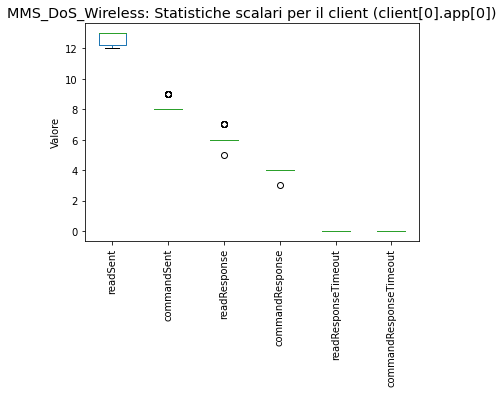

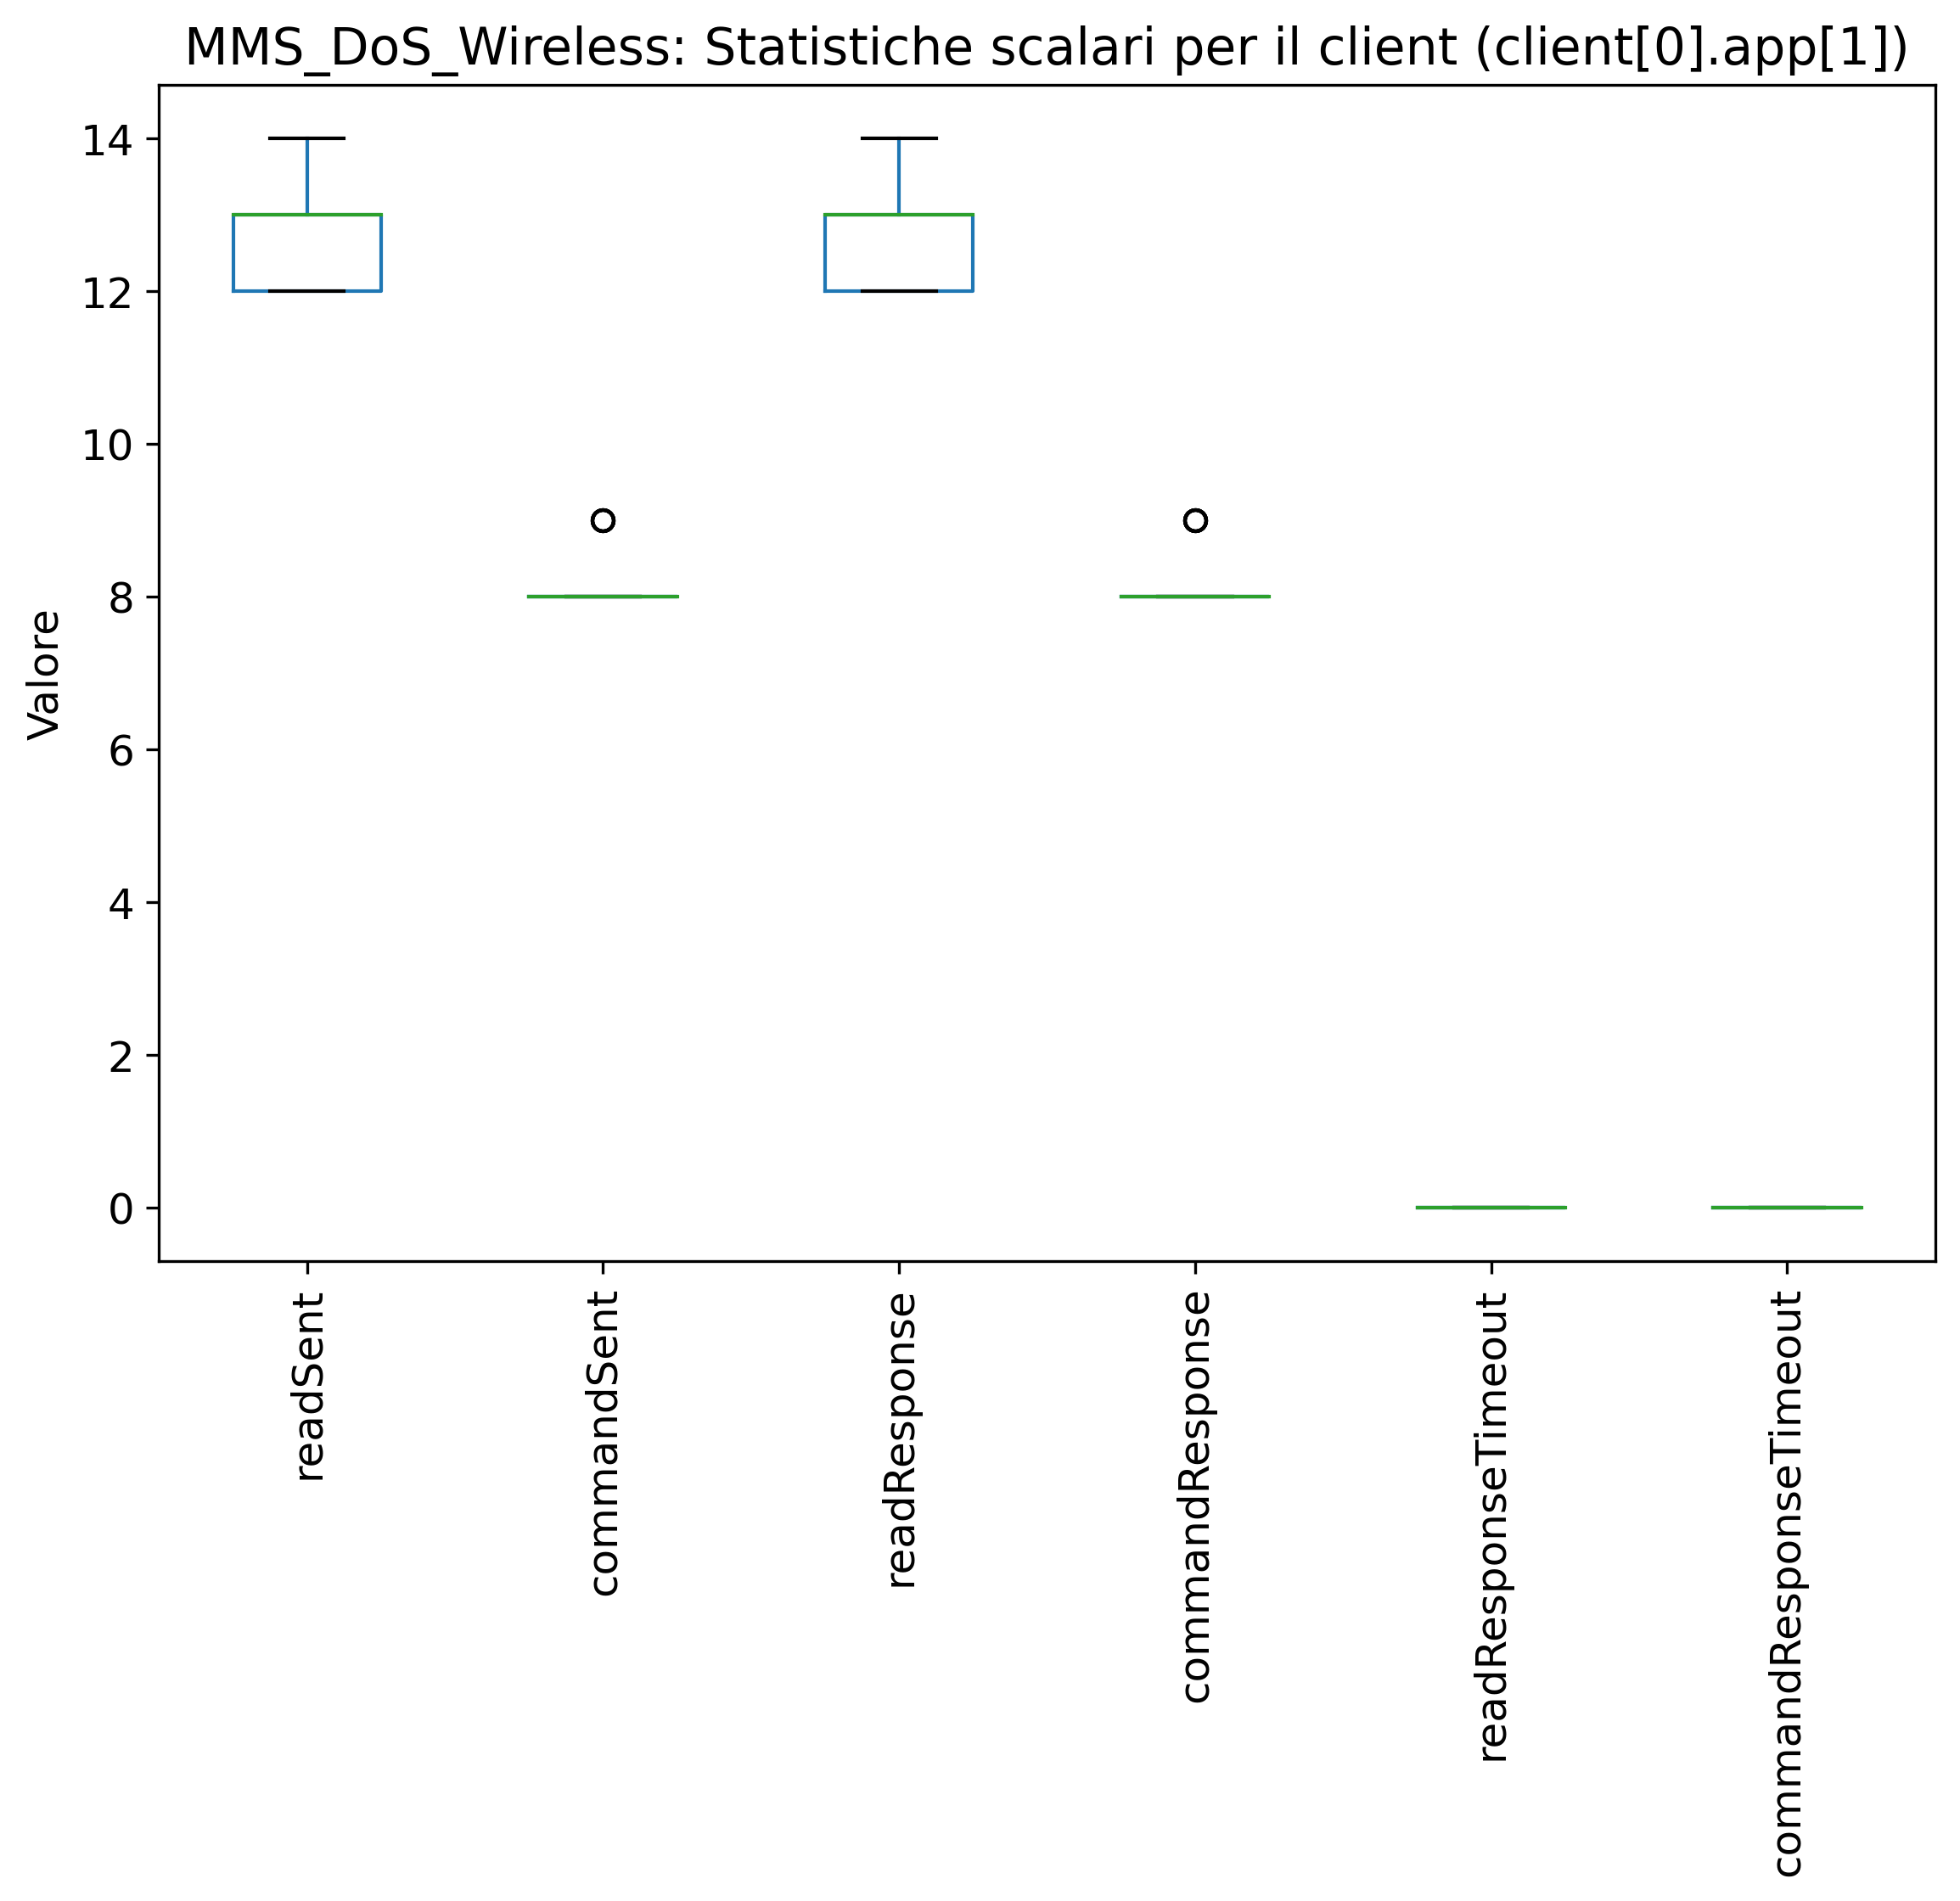

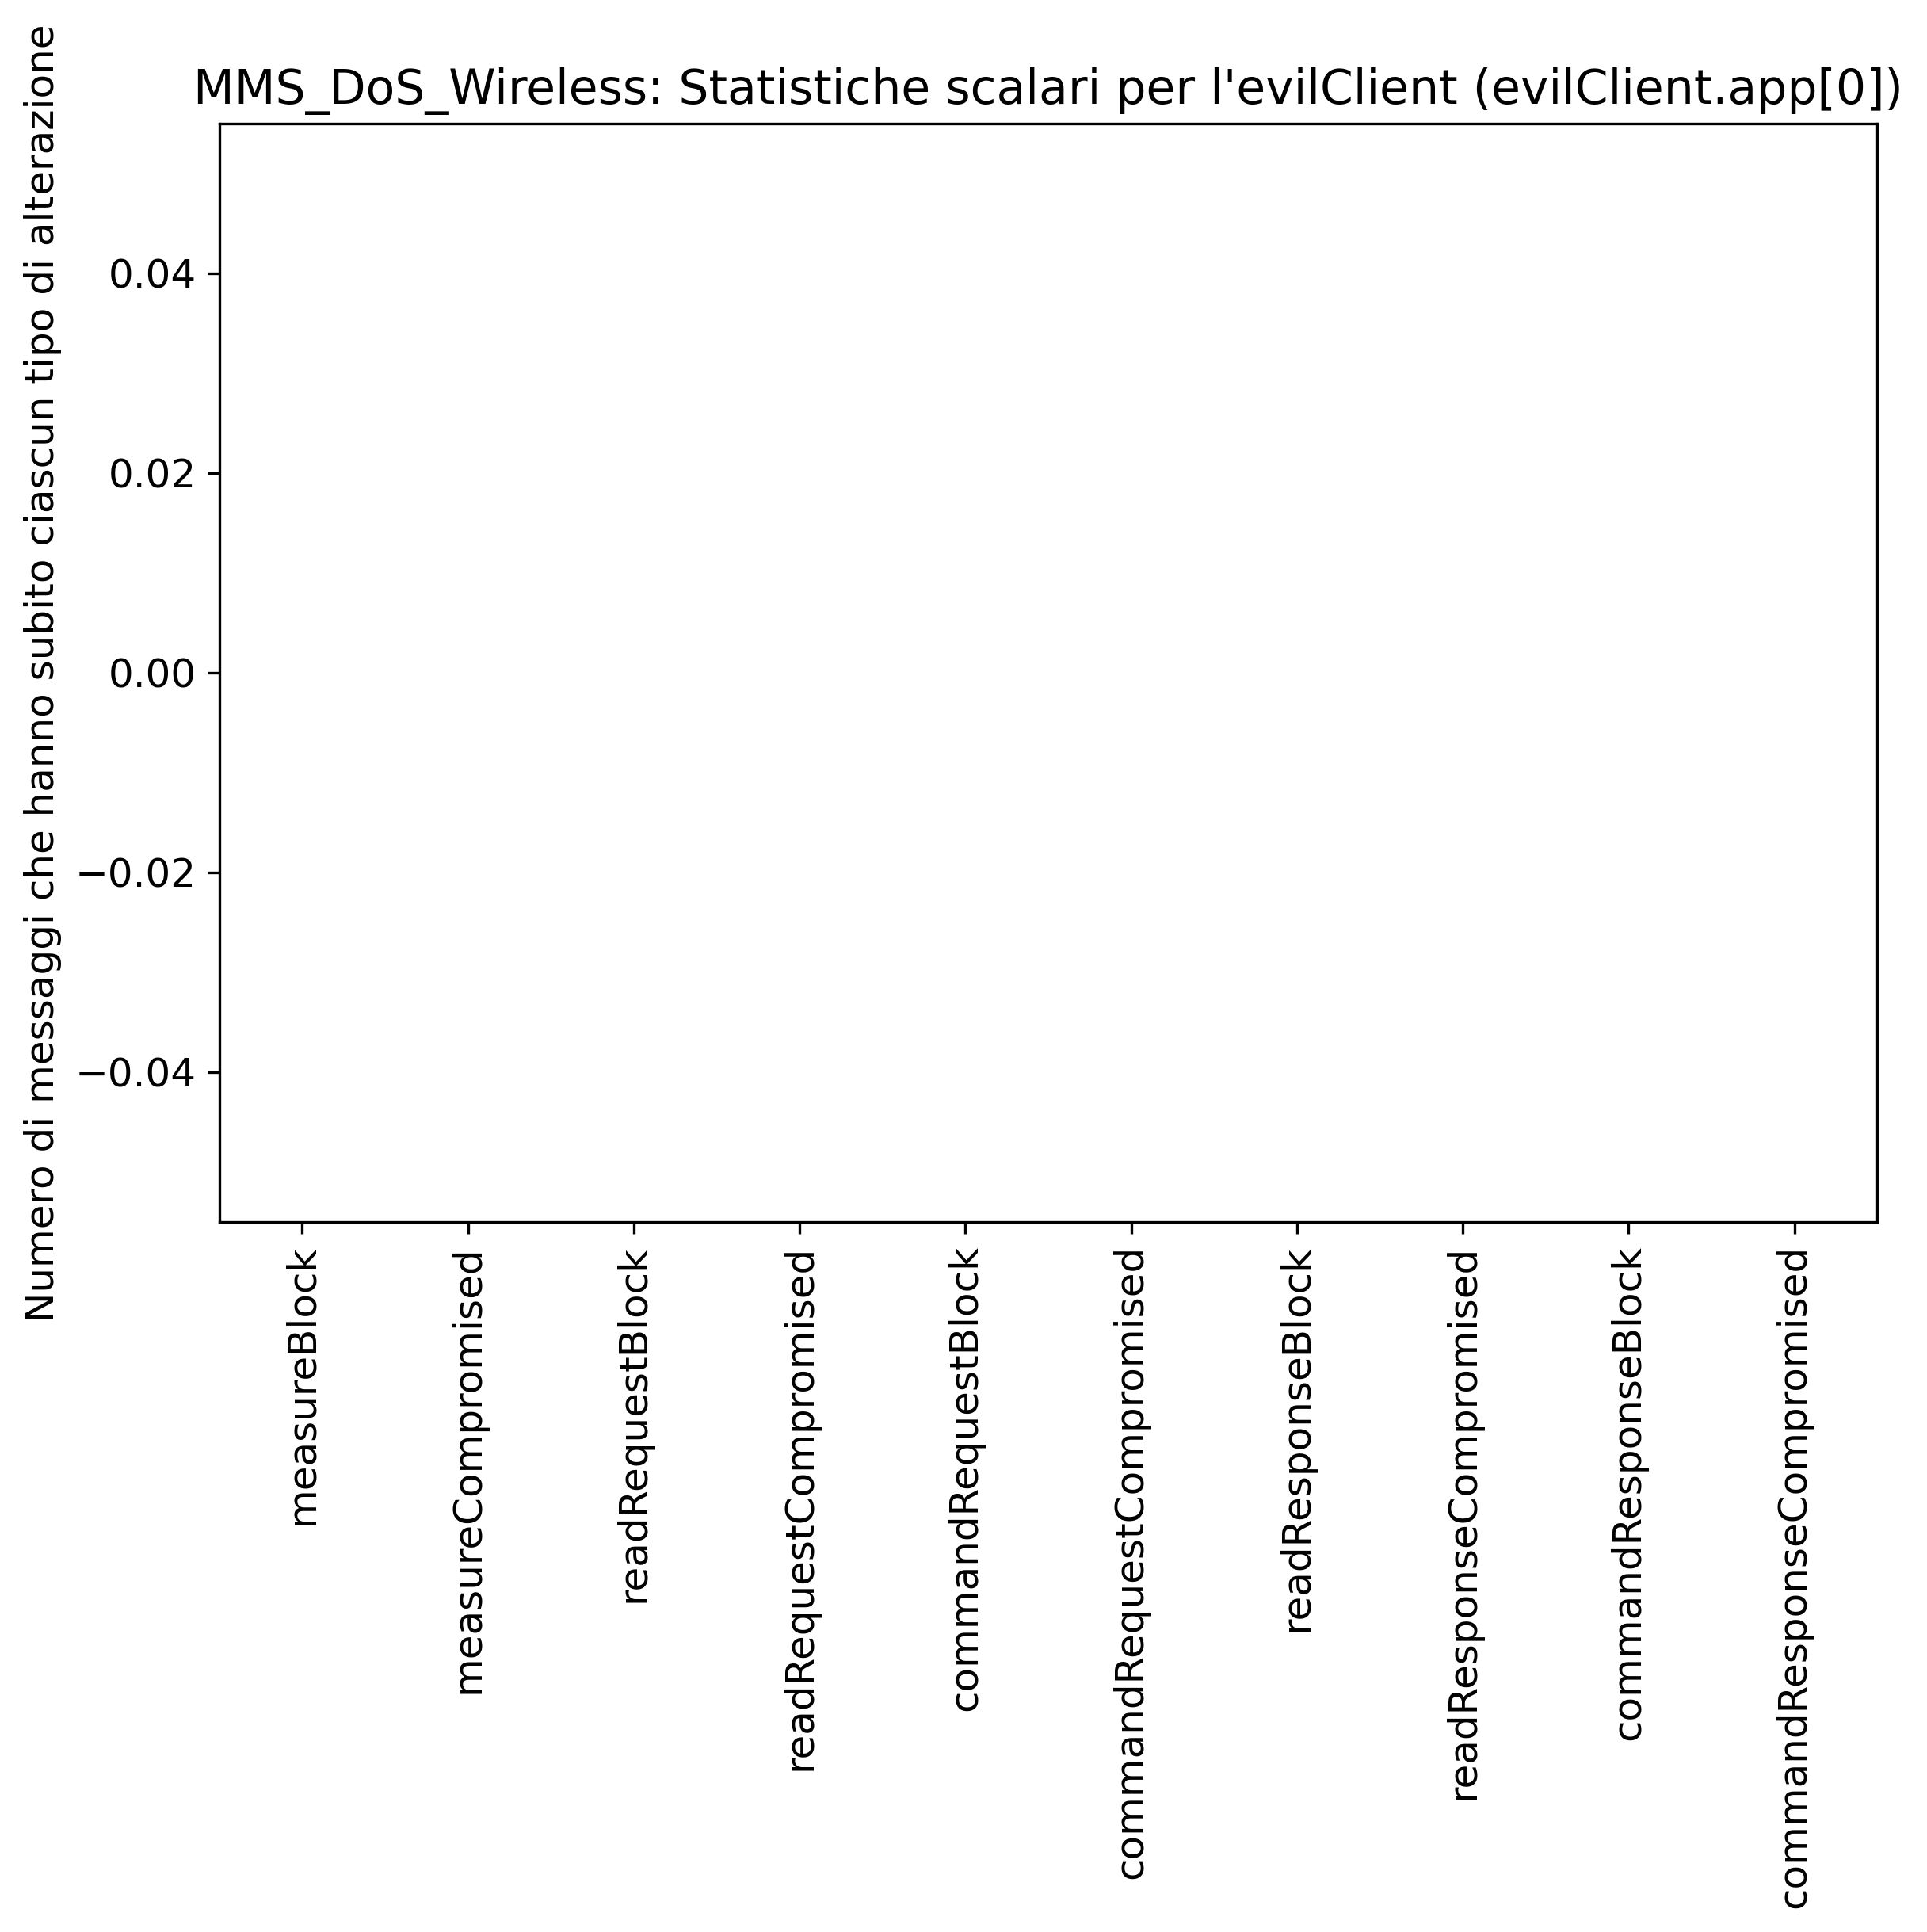

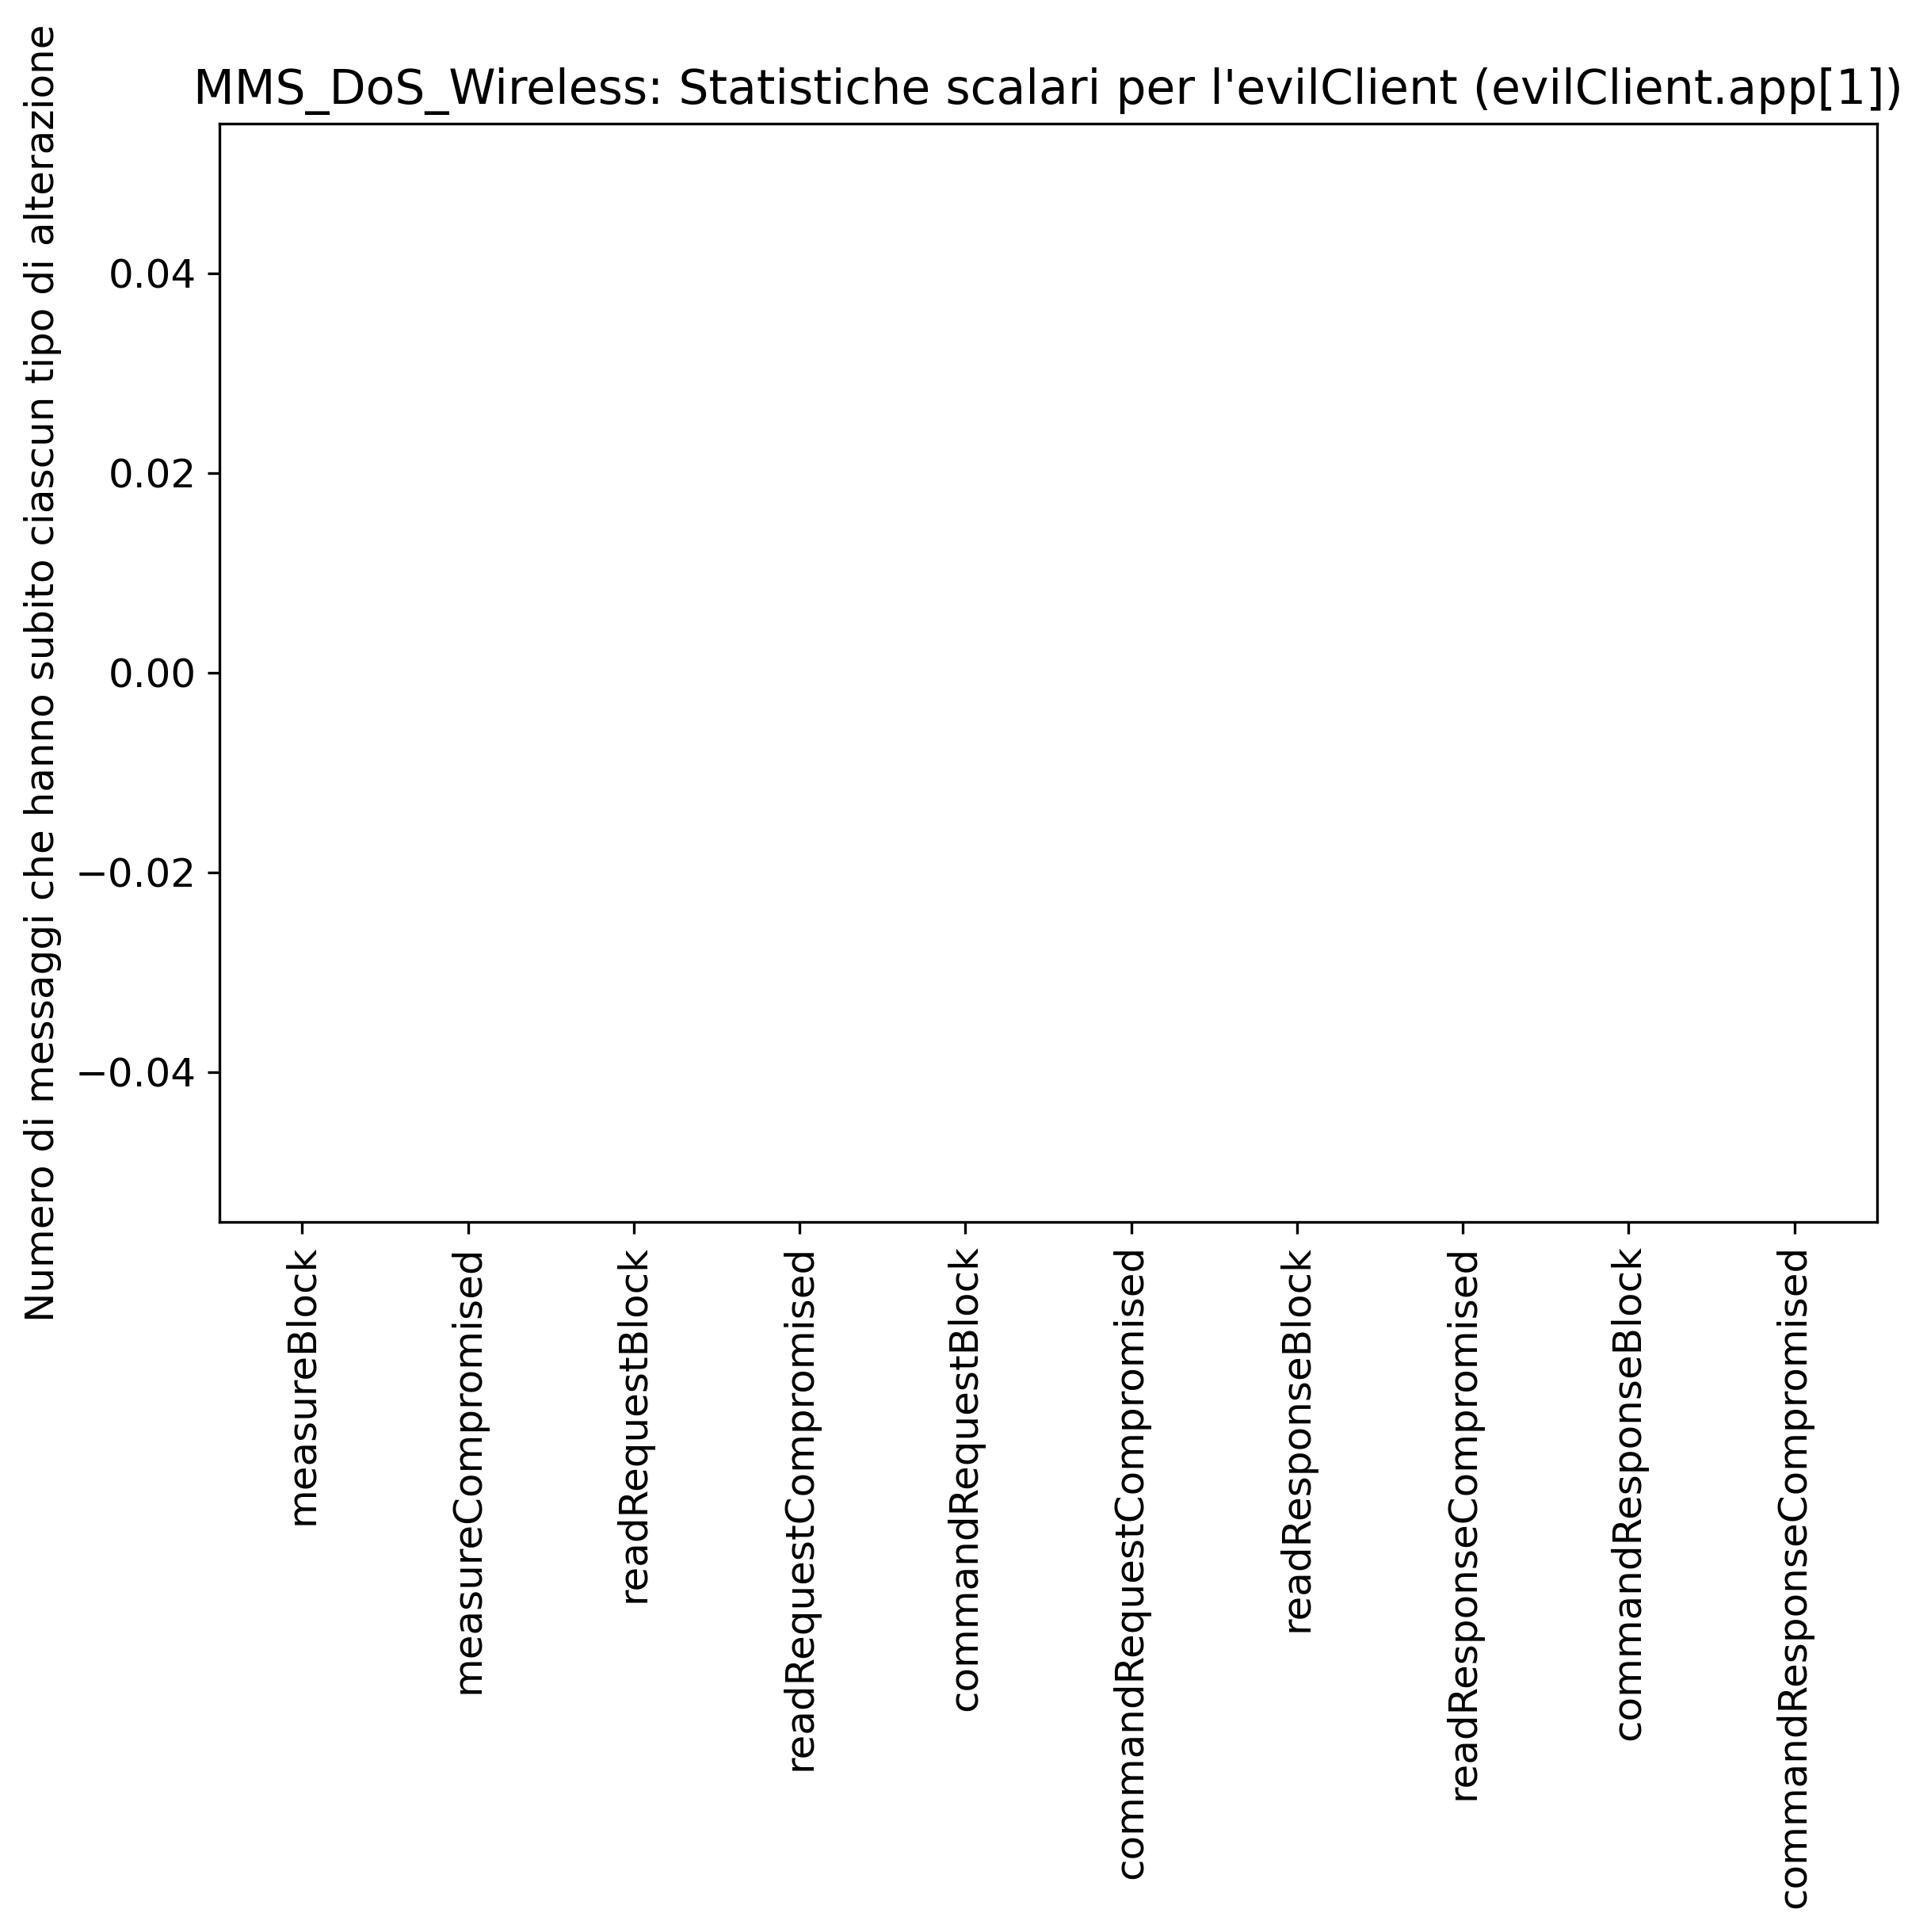

In [8]:
cliScaDfList = plotBoxWiskerSca(cliMeasNames, numClients, numServers, title=simName + ": Statistiche scalari per il client", yLab="Valore")
evilScaDfList = plotBoxWiskerSca(evilMeasNames, 1, numServers, cli="evilClient", title=simName + ": Statistiche scalari per l'evilClient", yLab="Numero di messaggi che hanno subito ciascun tipo di alterazione")

Scatter Matrices for clients

In [9]:
for i in range(numClients):
    for j in range(numServers):
        df = cliScaDfList[(i+1)*j]
        print("## Data description for client[" + str(i) + "].app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        #pd.plotting.scatter_matrix(df, figsize=(22,22))
        #plt.suptitle("Scatter Matrix for client[" + str(i) + "].app[" + str(j) + "]")


## Data description for client[0].app[0] ##
        readSent  commandSent  readResponse  commandResponse  \
count  50.000000    50.000000     50.000000        50.000000   
mean   12.740000     8.240000      6.100000         3.980000   
std     0.443087     0.431419      0.364216         0.141421   
min    12.000000     8.000000      5.000000         3.000000   
25%    12.250000     8.000000      6.000000         4.000000   
50%    13.000000     8.000000      6.000000         4.000000   
75%    13.000000     8.000000      6.000000         4.000000   
max    13.000000     9.000000      7.000000         4.000000   

       readResponseTimeout  commandResponseTimeout  
count                 50.0                    50.0  
mean                   0.0                     0.0  
std                    0.0                     0.0  
min                    0.0                     0.0  
25%                    0.0                     0.0  
50%                    0.0                     0.0  
75%     

Scatter matrix for the evilClient

In [10]:
if not isDos:
    for j in range(numServers):
        df = evilScaDfList[j]
        print("## Data description for evilClient.app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        #pd.plotting.scatter_matrix(df, figsize=(25,25))
        #plt.suptitle("Scatter Matrix for evilClient.app[" + str(j) + "]")

[(0, 15.0), (15.0, 30.0), (30.0, 45.0), (45.0, 60.0), (60.0, 75.0), (75.0, 90.0), (90.0, 105.0), (105.0, 120.0)]


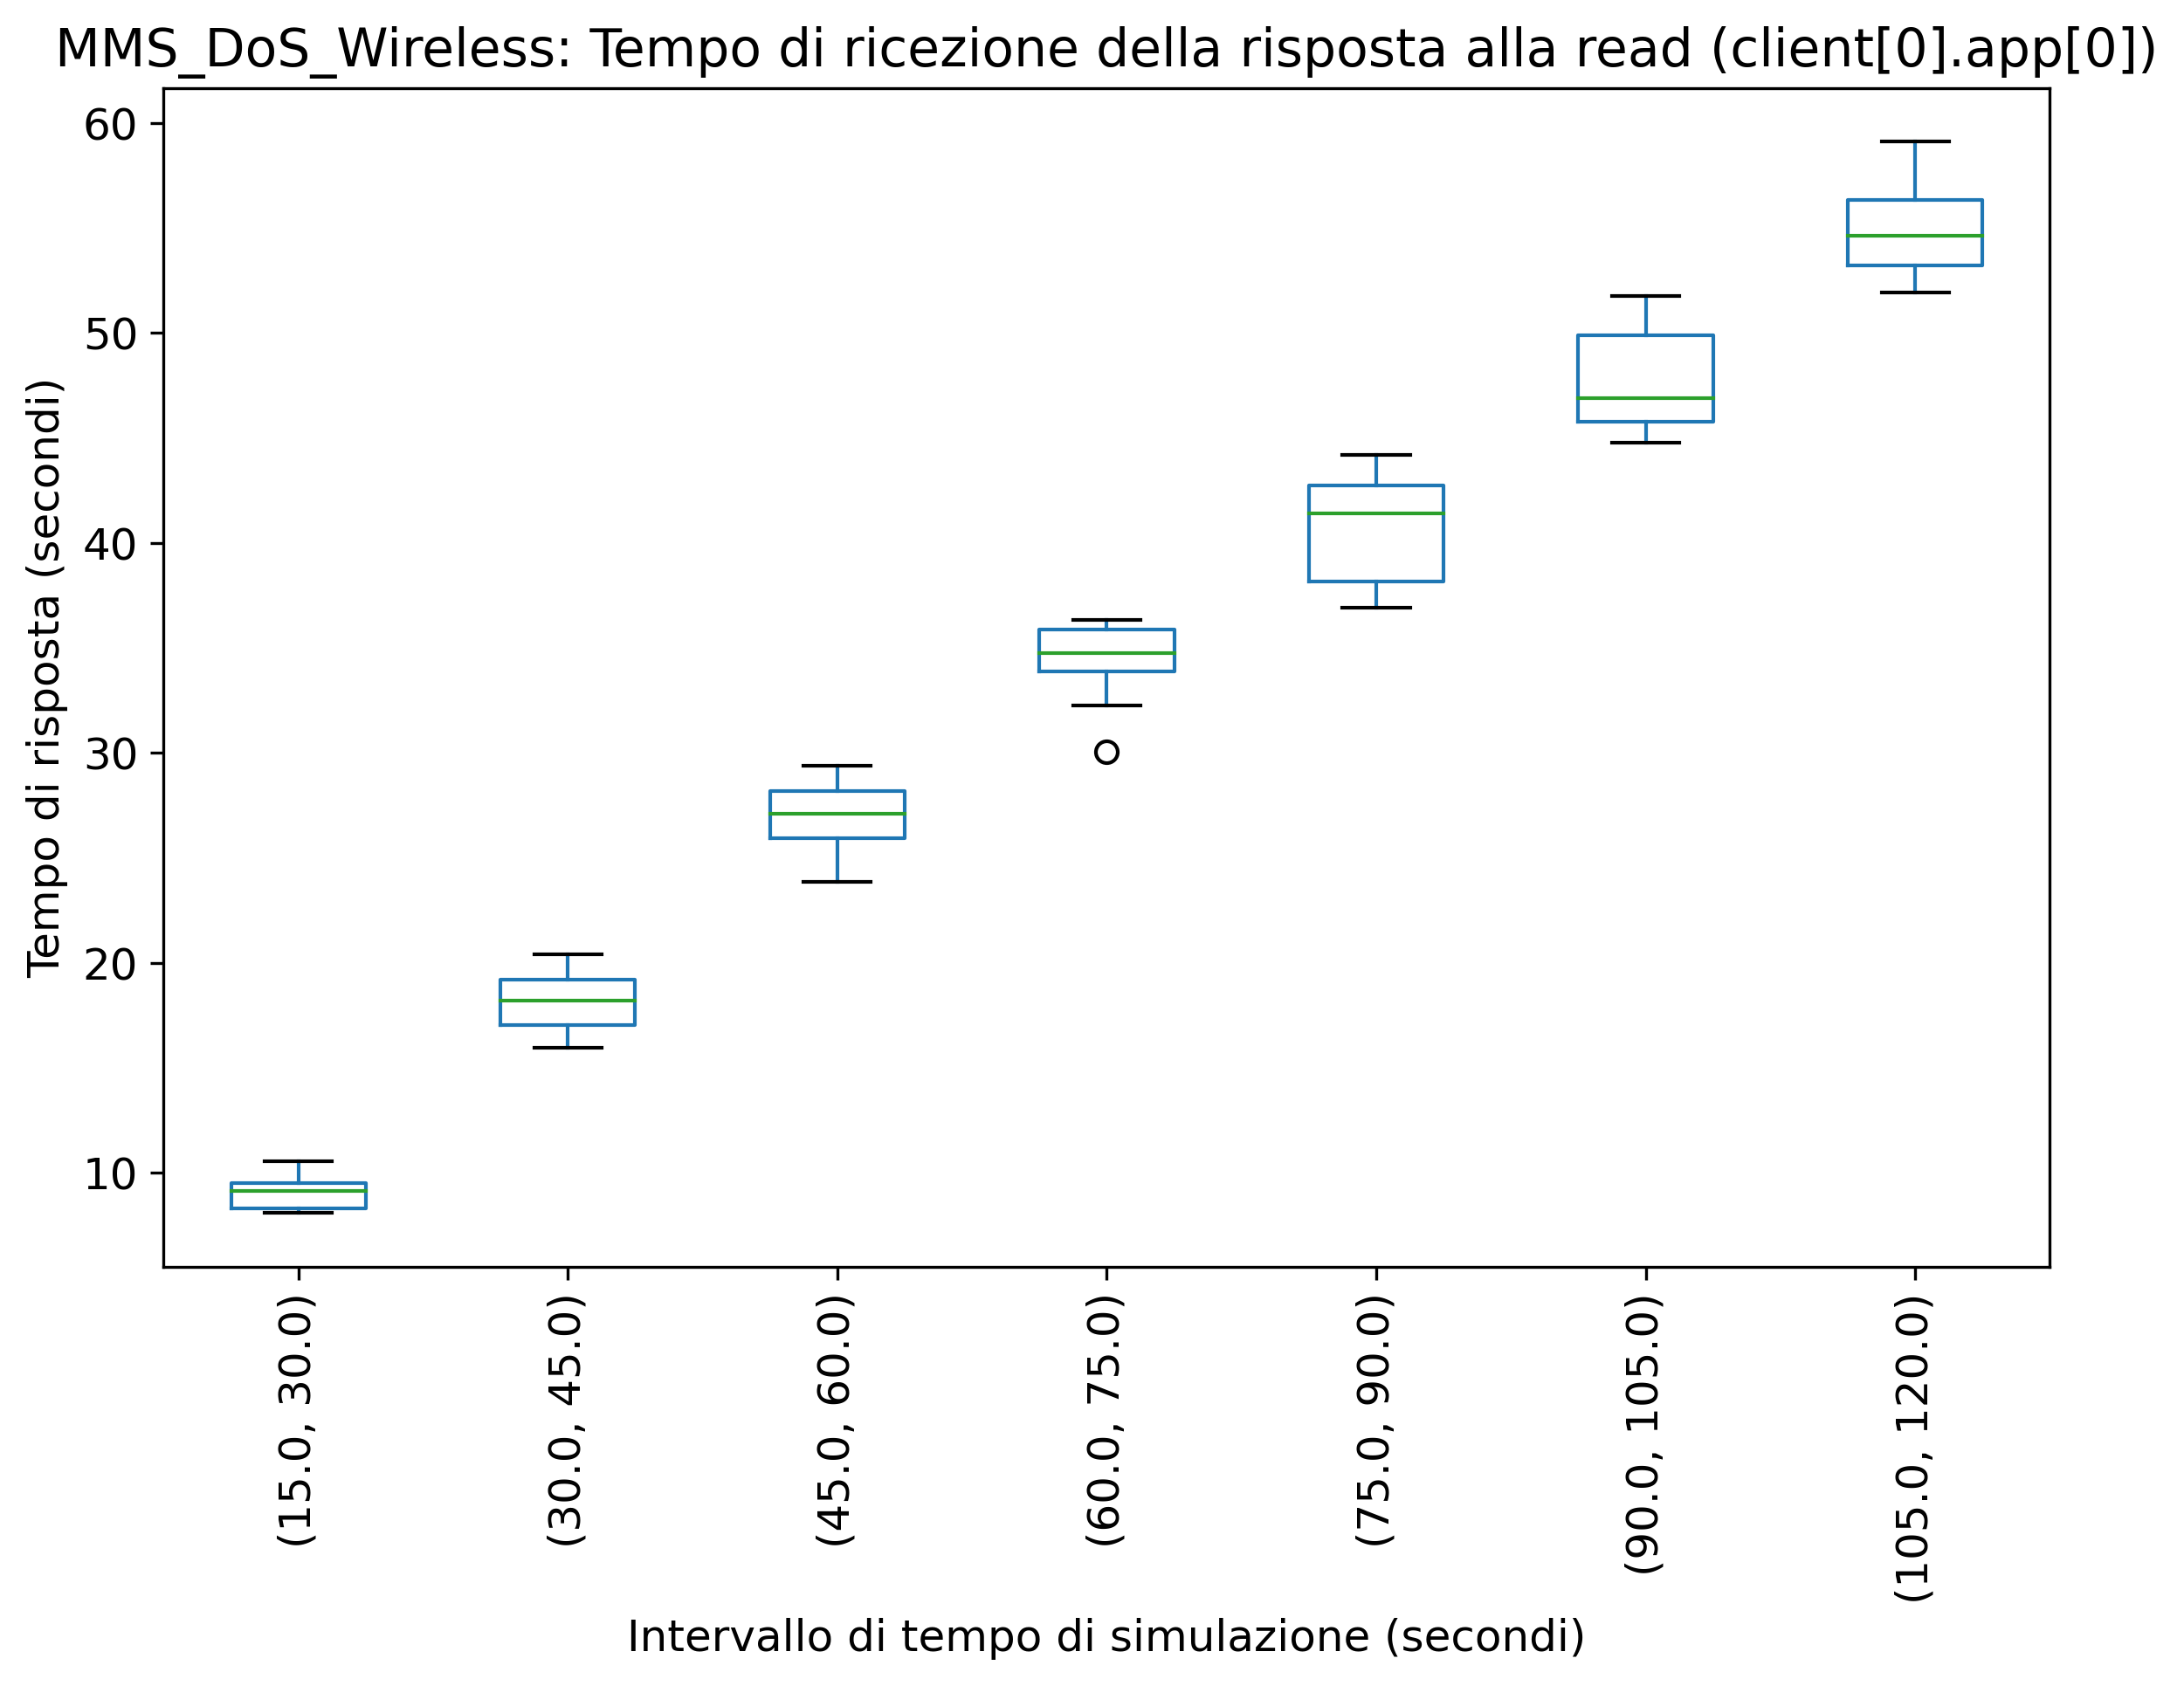

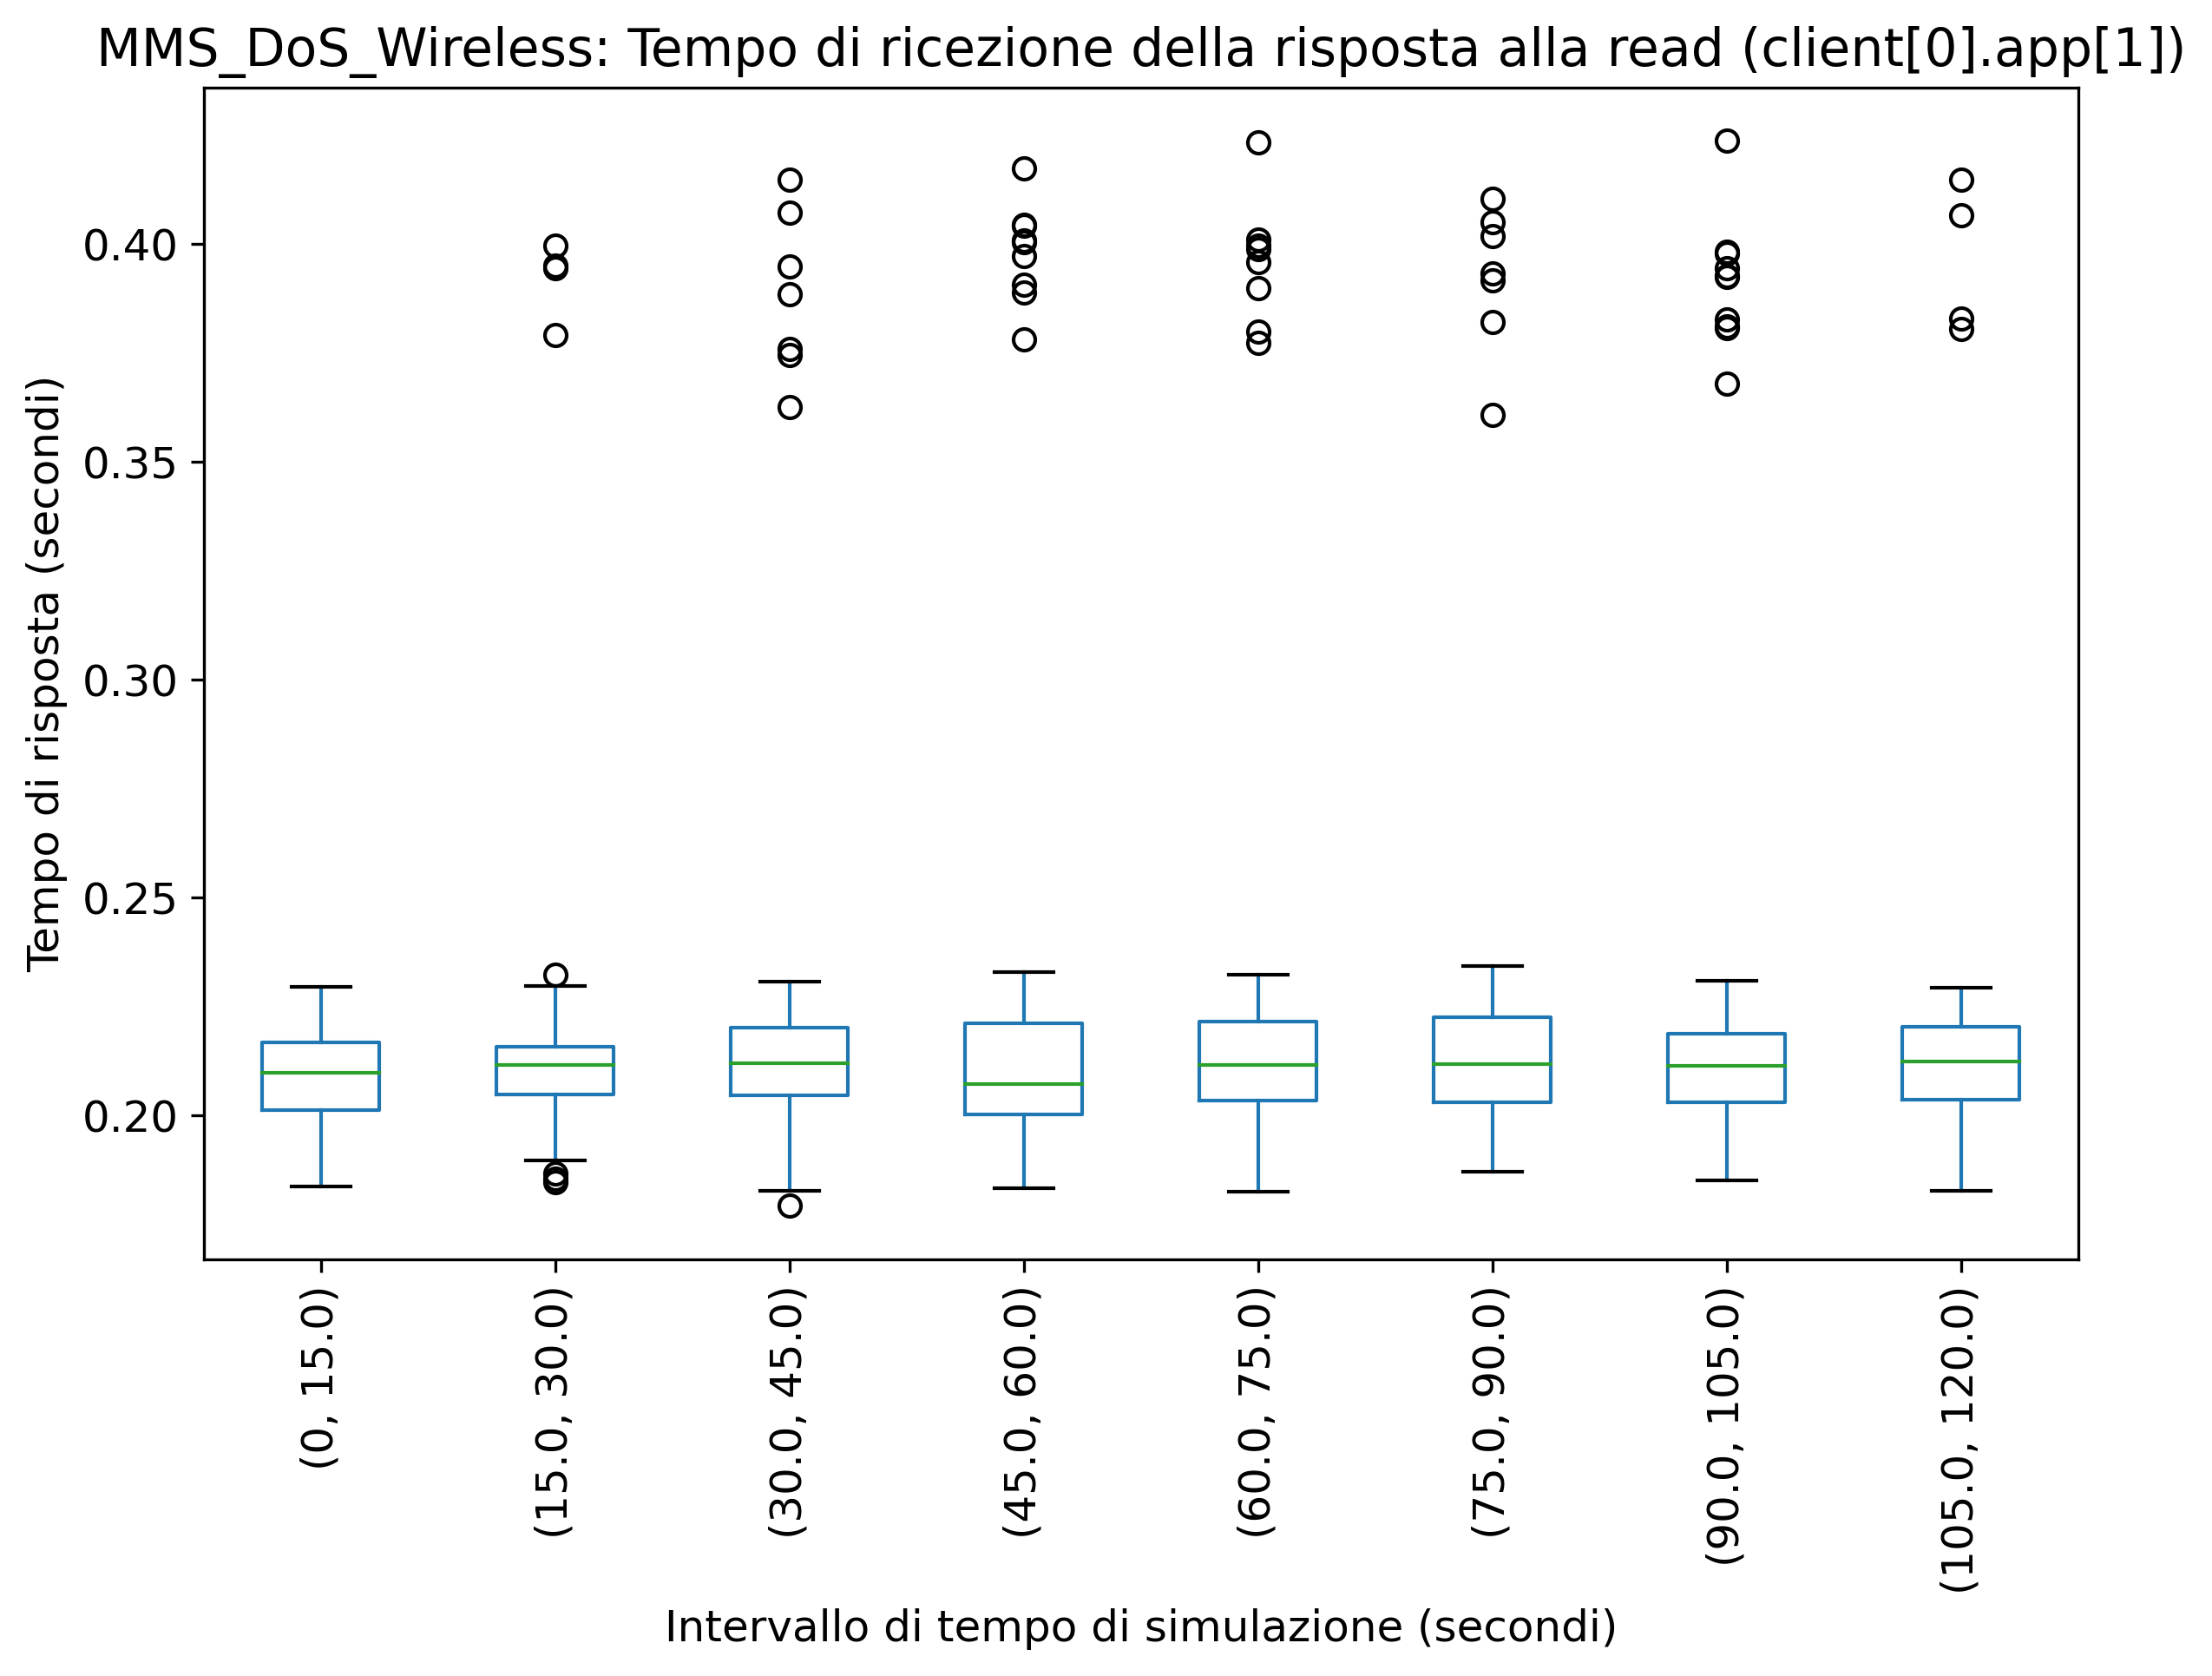

[(0, 20.0), (20.0, 40.0), (40.0, 60.0), (60.0, 80.0), (80.0, 100.0), (100.0, 120.0)]


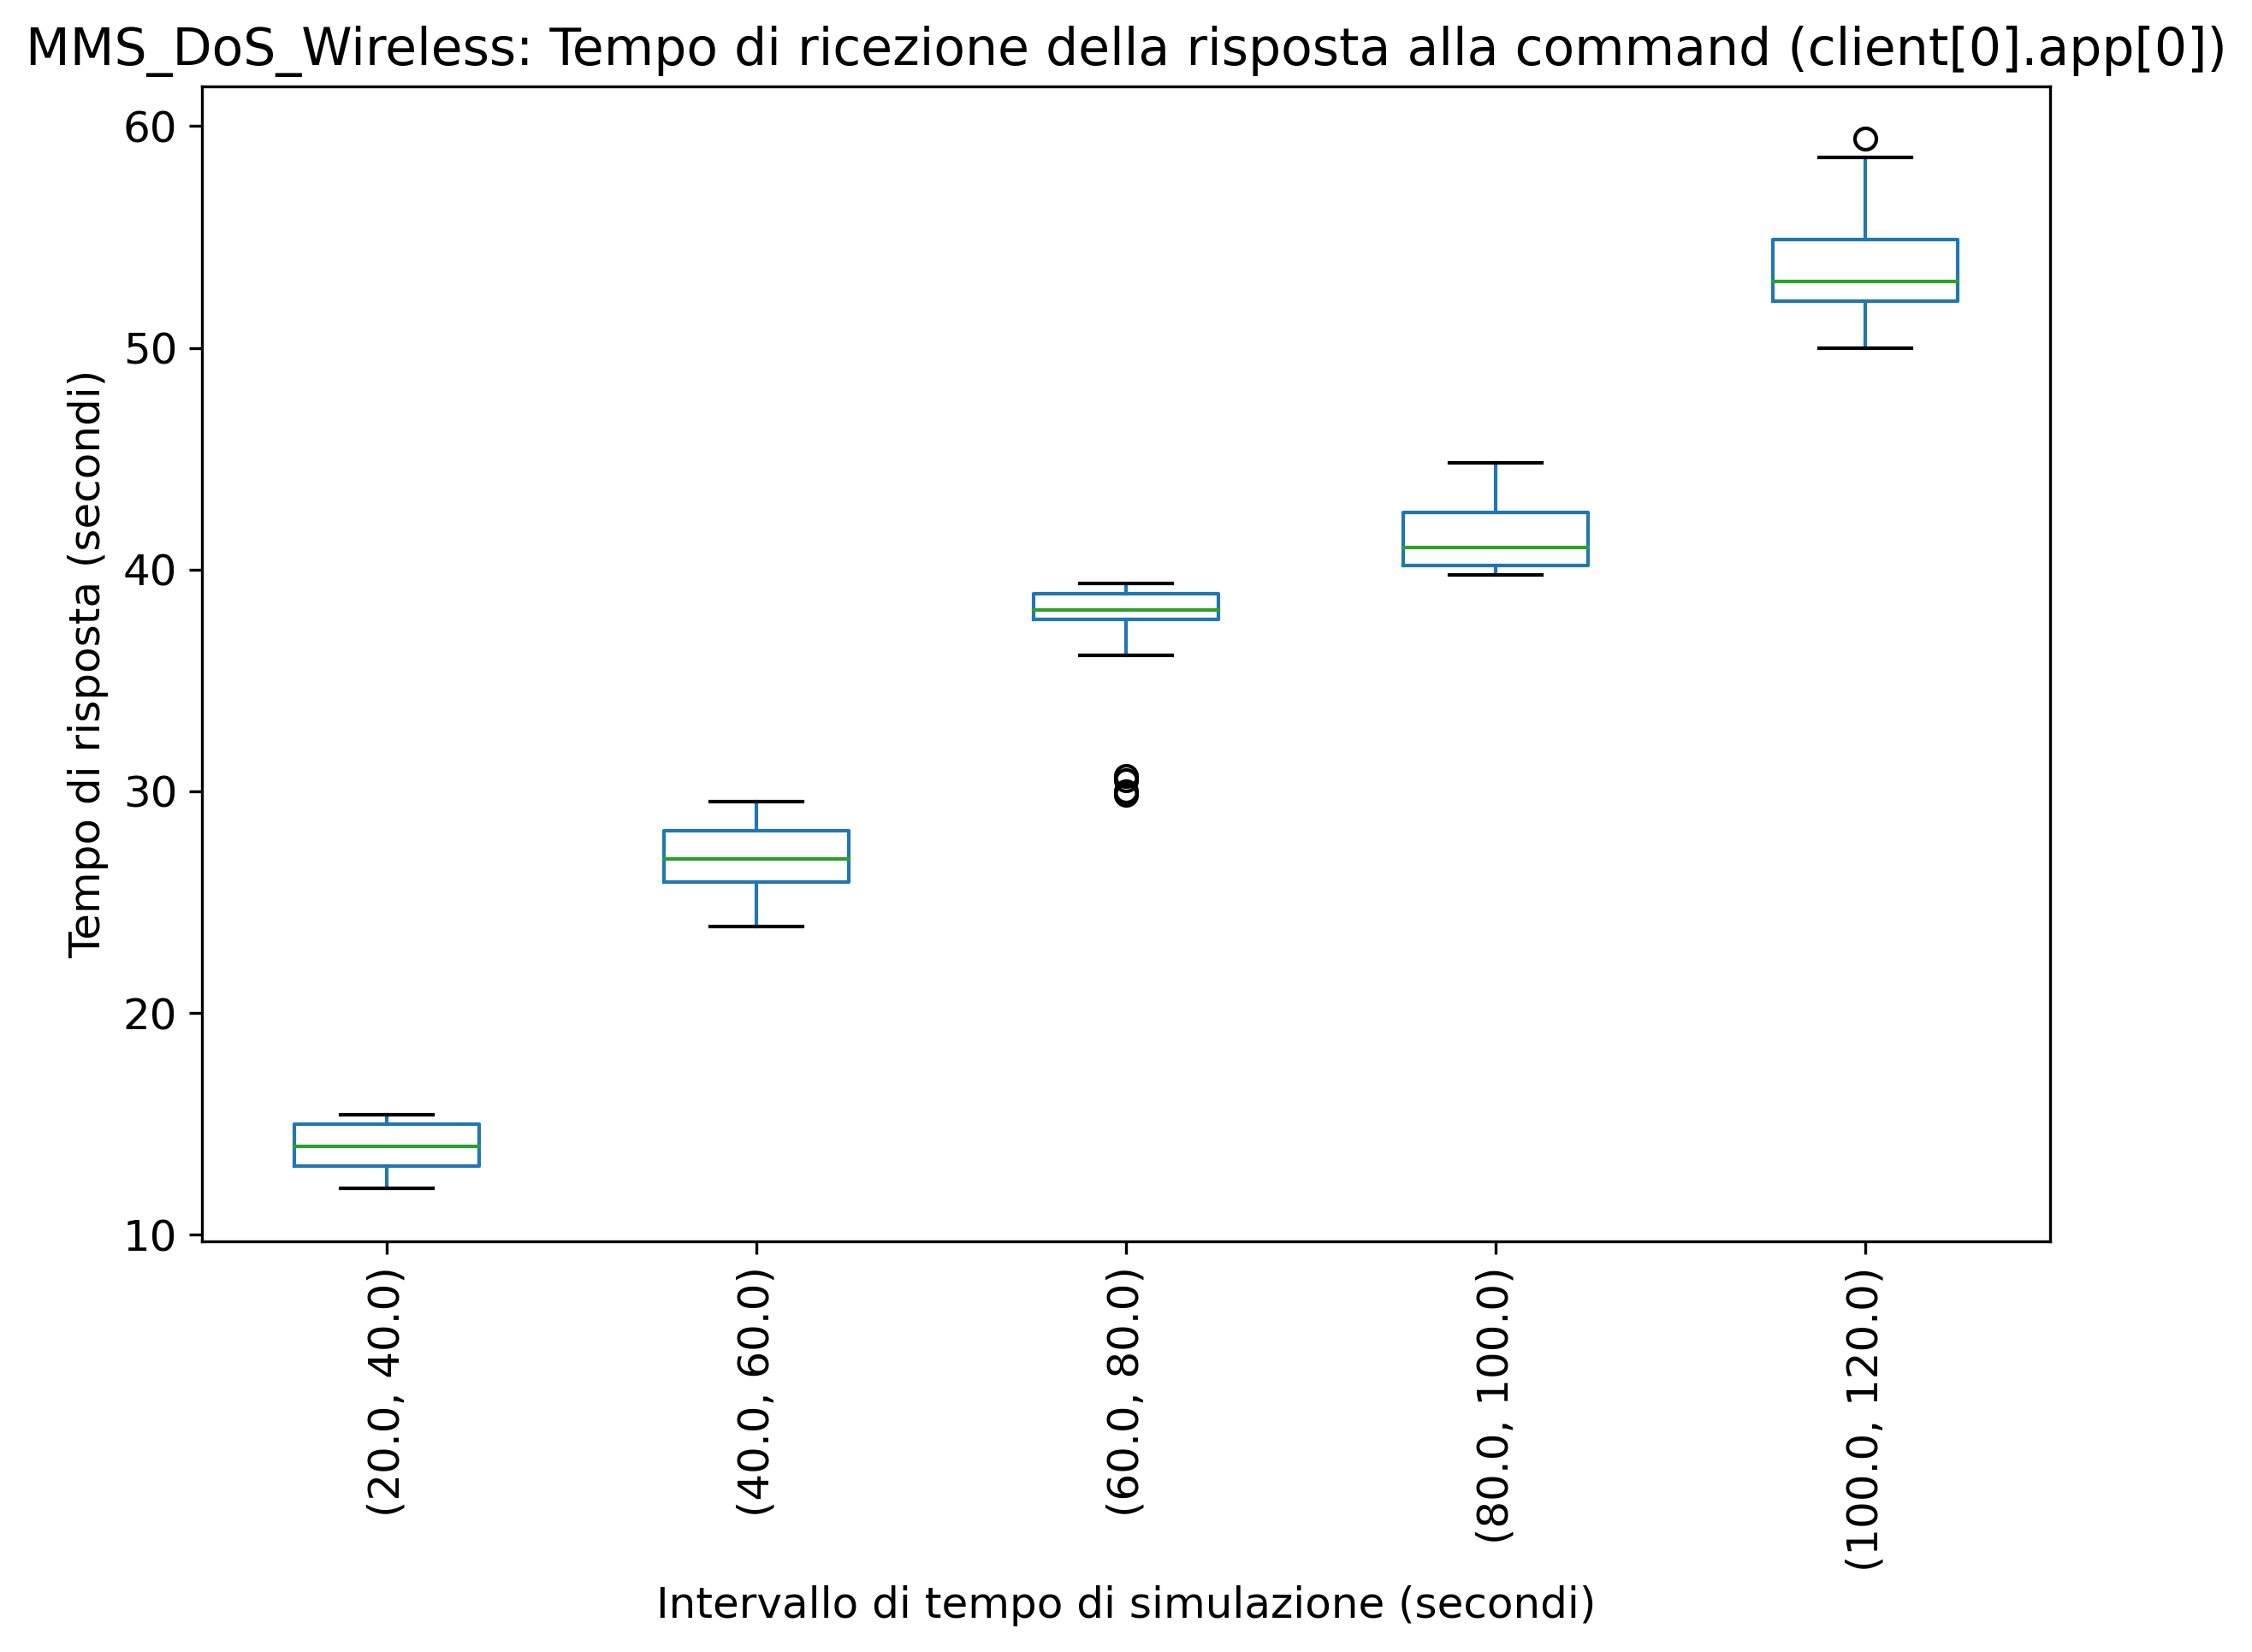

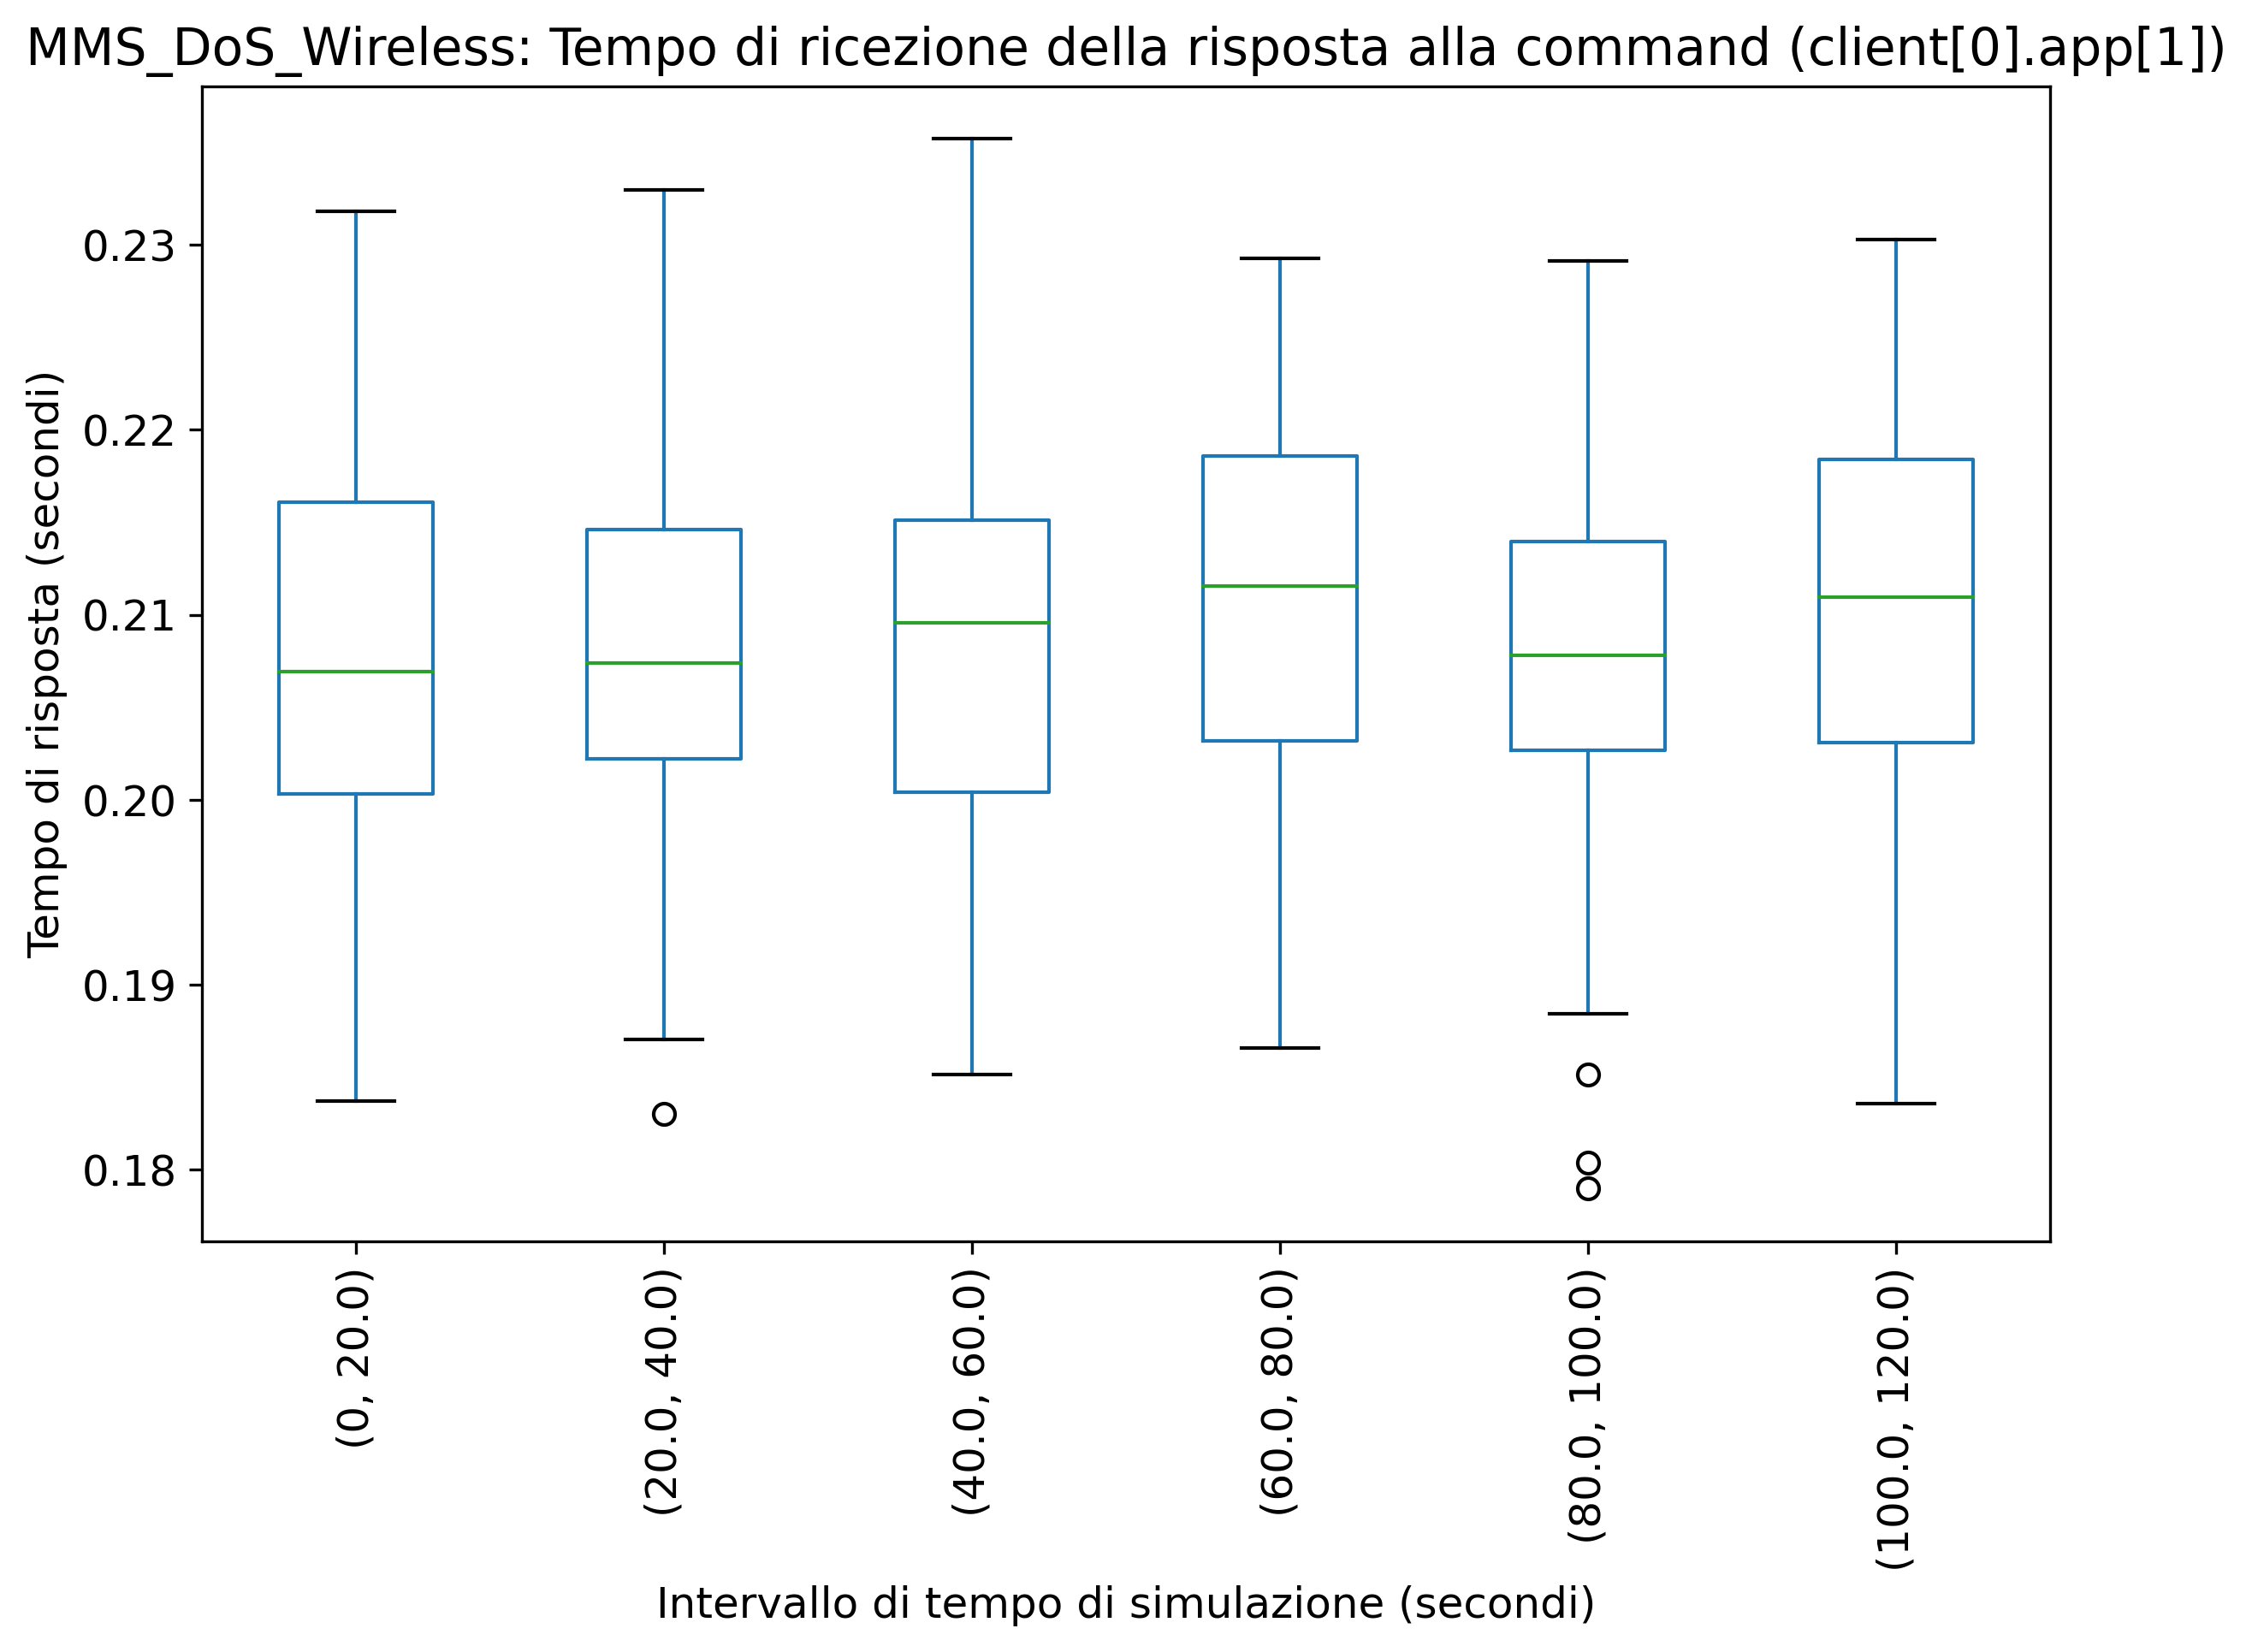

[]


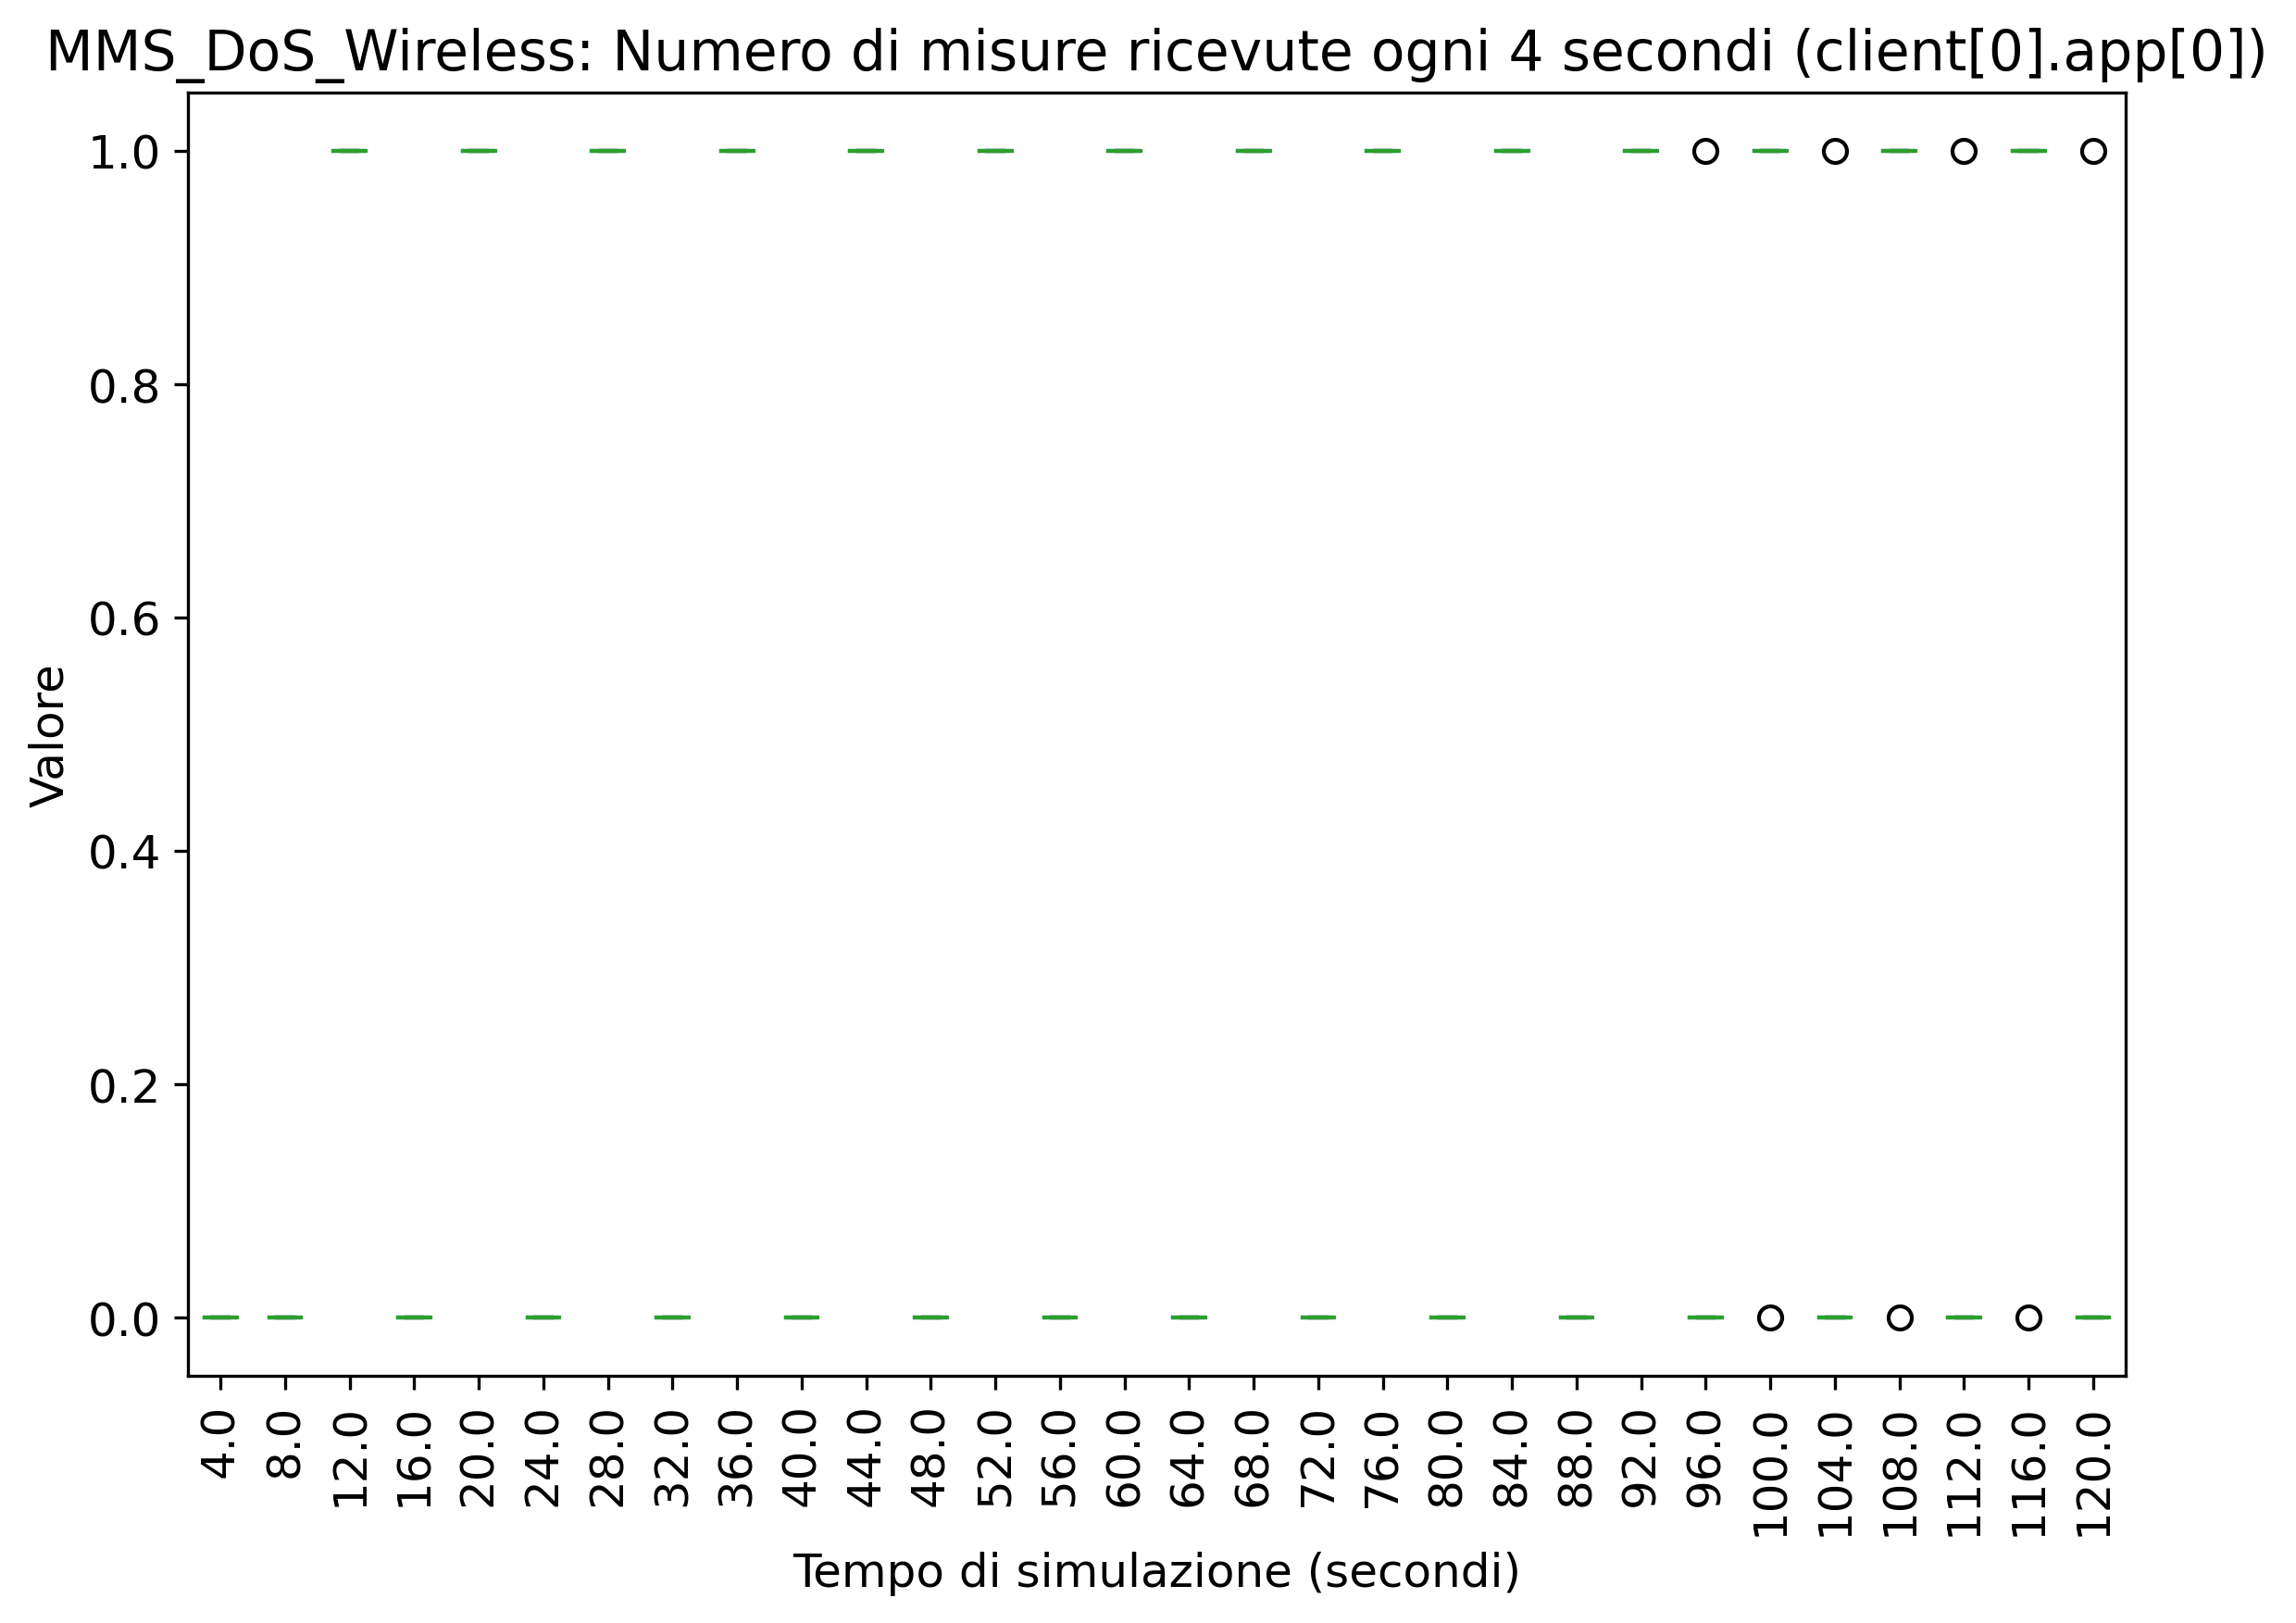

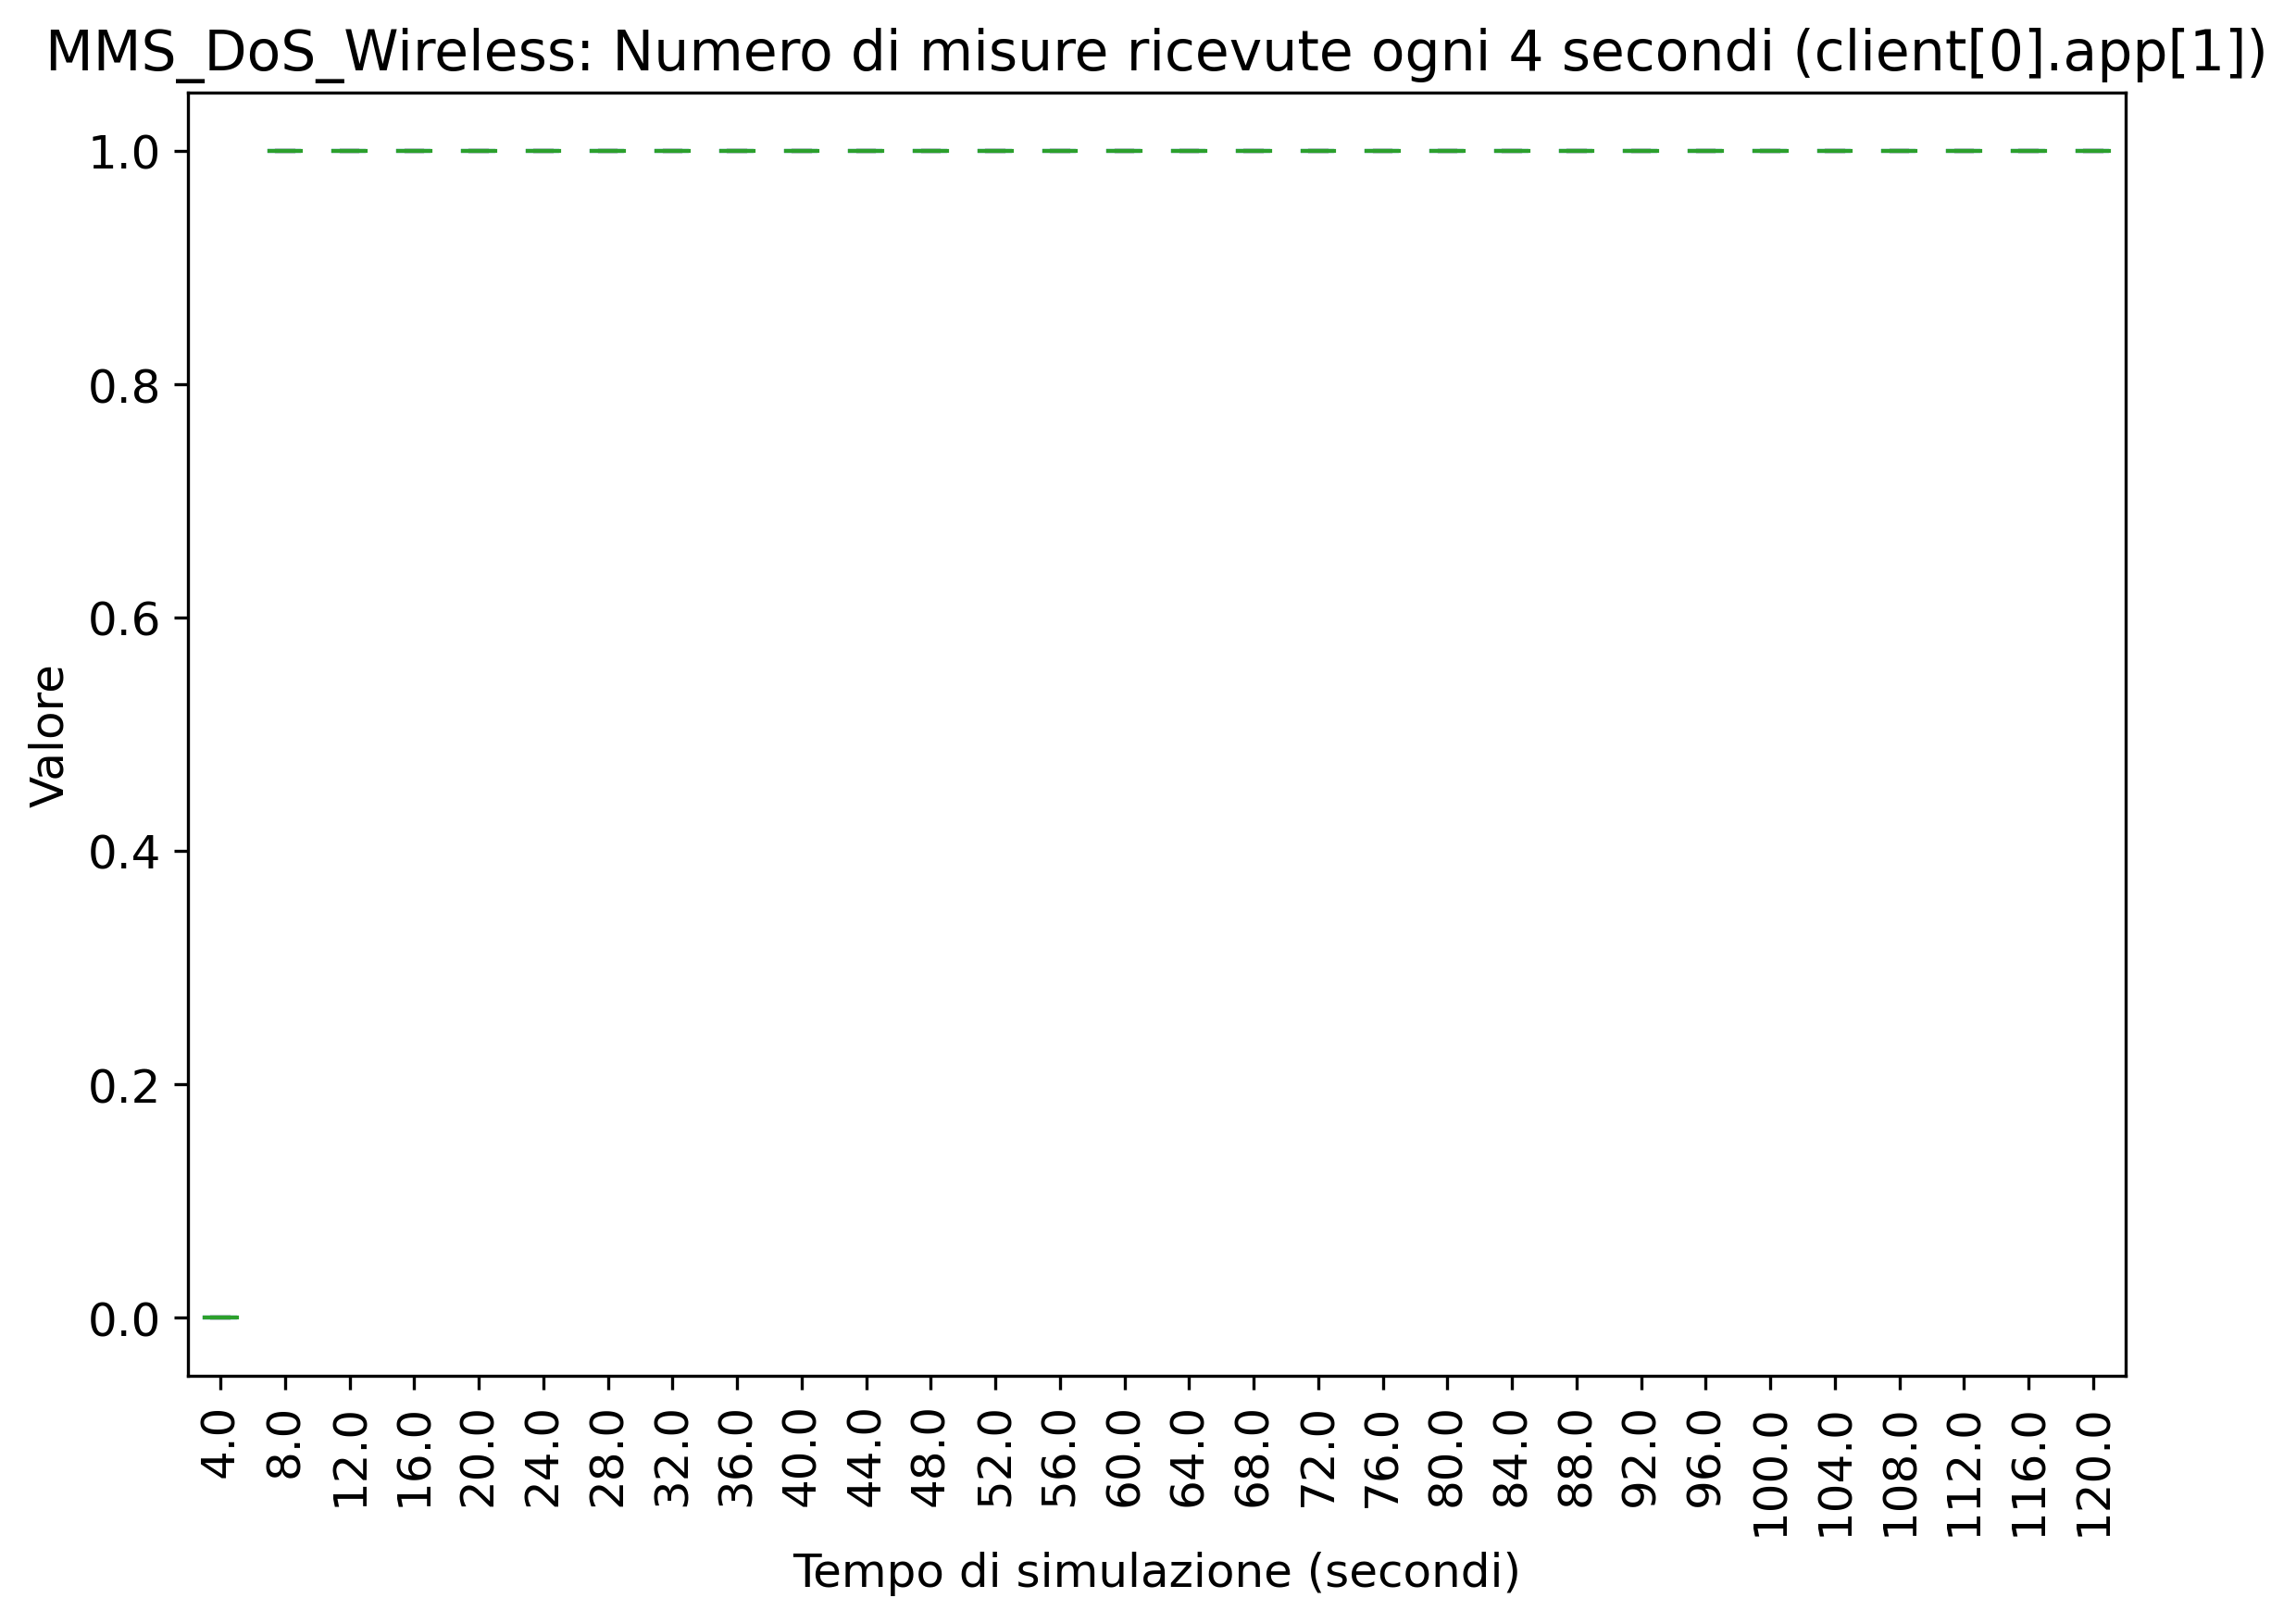

In [11]:
cliVecDfListReadTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read", xLab = "Intervallo di tempo di simulazione (secondi)", yLab = "Tempo di risposta (secondi)", vecMeasName="readResponseReceivedTime", numRanges = 8)
cliVecDfListCommandTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command", xLab = "Intervallo di tempo di simulazione (secondi)", yLab = "Tempo di risposta (secondi)", vecMeasName="commandResponseReceivedTime", numRanges = 6)
cliVecDfListMeasRec = plotBoxWiskerVec(numClients, numServers, title=simName + ": Numero di misure ricevute ogni 4 secondi", xLab = "Tempo di simulazione (secondi)", yLab = "Valore", vecMeasName="measureReceivedAmount", numRanges = 0)

In [12]:
def plotPointsVec(numClients, numServers, title = "", xLab = "", yLab = "", cli = "client", vecMeasName = "measureReceivedAmount"):
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            fig, axes = plt.subplots(nrows=1, ncols=1)
            fig.set_figheight(6)
            fig.set_figwidth(9)
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            
            colPlot = pd.DataFrame(columns=["value", "time", "color"])
            rowNum = 0
            colors = cm.rainbow(np.linspace(0, 1, len(flt["runID"])))
            for row, color in zip(flt.itertuples(), colors):
                vecValue = pd.Series(row.vecvalue)
                vecTime = pd.Series(row.vectime)
                for val, time in zip(vecValue, vecTime):    
                    colPlot.loc[rowNum] = list((val, time, color))
                    rowNum += 1
                                
            outVec.append(colPlot)
            if DEBUG:
                colPlot.to_csv("./out.csv", mode="w", header=True)

            axes.scatter("time", "value", data=colPlot, c="blue")#colPlot["color"]
            axes.set_title(title + " (" + strElem + ")", fontstyle='italic') 
            axes.set_xlabel(xLab)
            axes.set_ylabel(yLab)  
            print("Avg: " + str(np.mean(colPlot["value"])))   
            print("Std: " + str(np.std(colPlot["value"]))) 
            interval = scipy.stats.t.interval(0.98, df=len(colPlot["value"])-1, loc=np.mean(colPlot["value"]), scale=scipy.stats.sem(colPlot["value"]))
            print("Confidence interval at 98%: " + str((interval[1] - interval[0])/2))
            print("****")            
    return outVec

Avg: 31.866866939668547
Std: 15.579202666986879
Confidence interval at 98%: 2.0896744053287577
****
Avg: 0.22374922370983466
Std: 0.05057365200386177
Confidence interval at 98%: 0.004706835112379182
****
Avg: 33.65676367787426
Std: 14.937220654170057
Confidence interval at 98%: 2.489664658202692
****
Avg: 0.20860985411824196
Std: 0.011335887074710128
Confidence interval at 98%: 0.001317242659162221
****


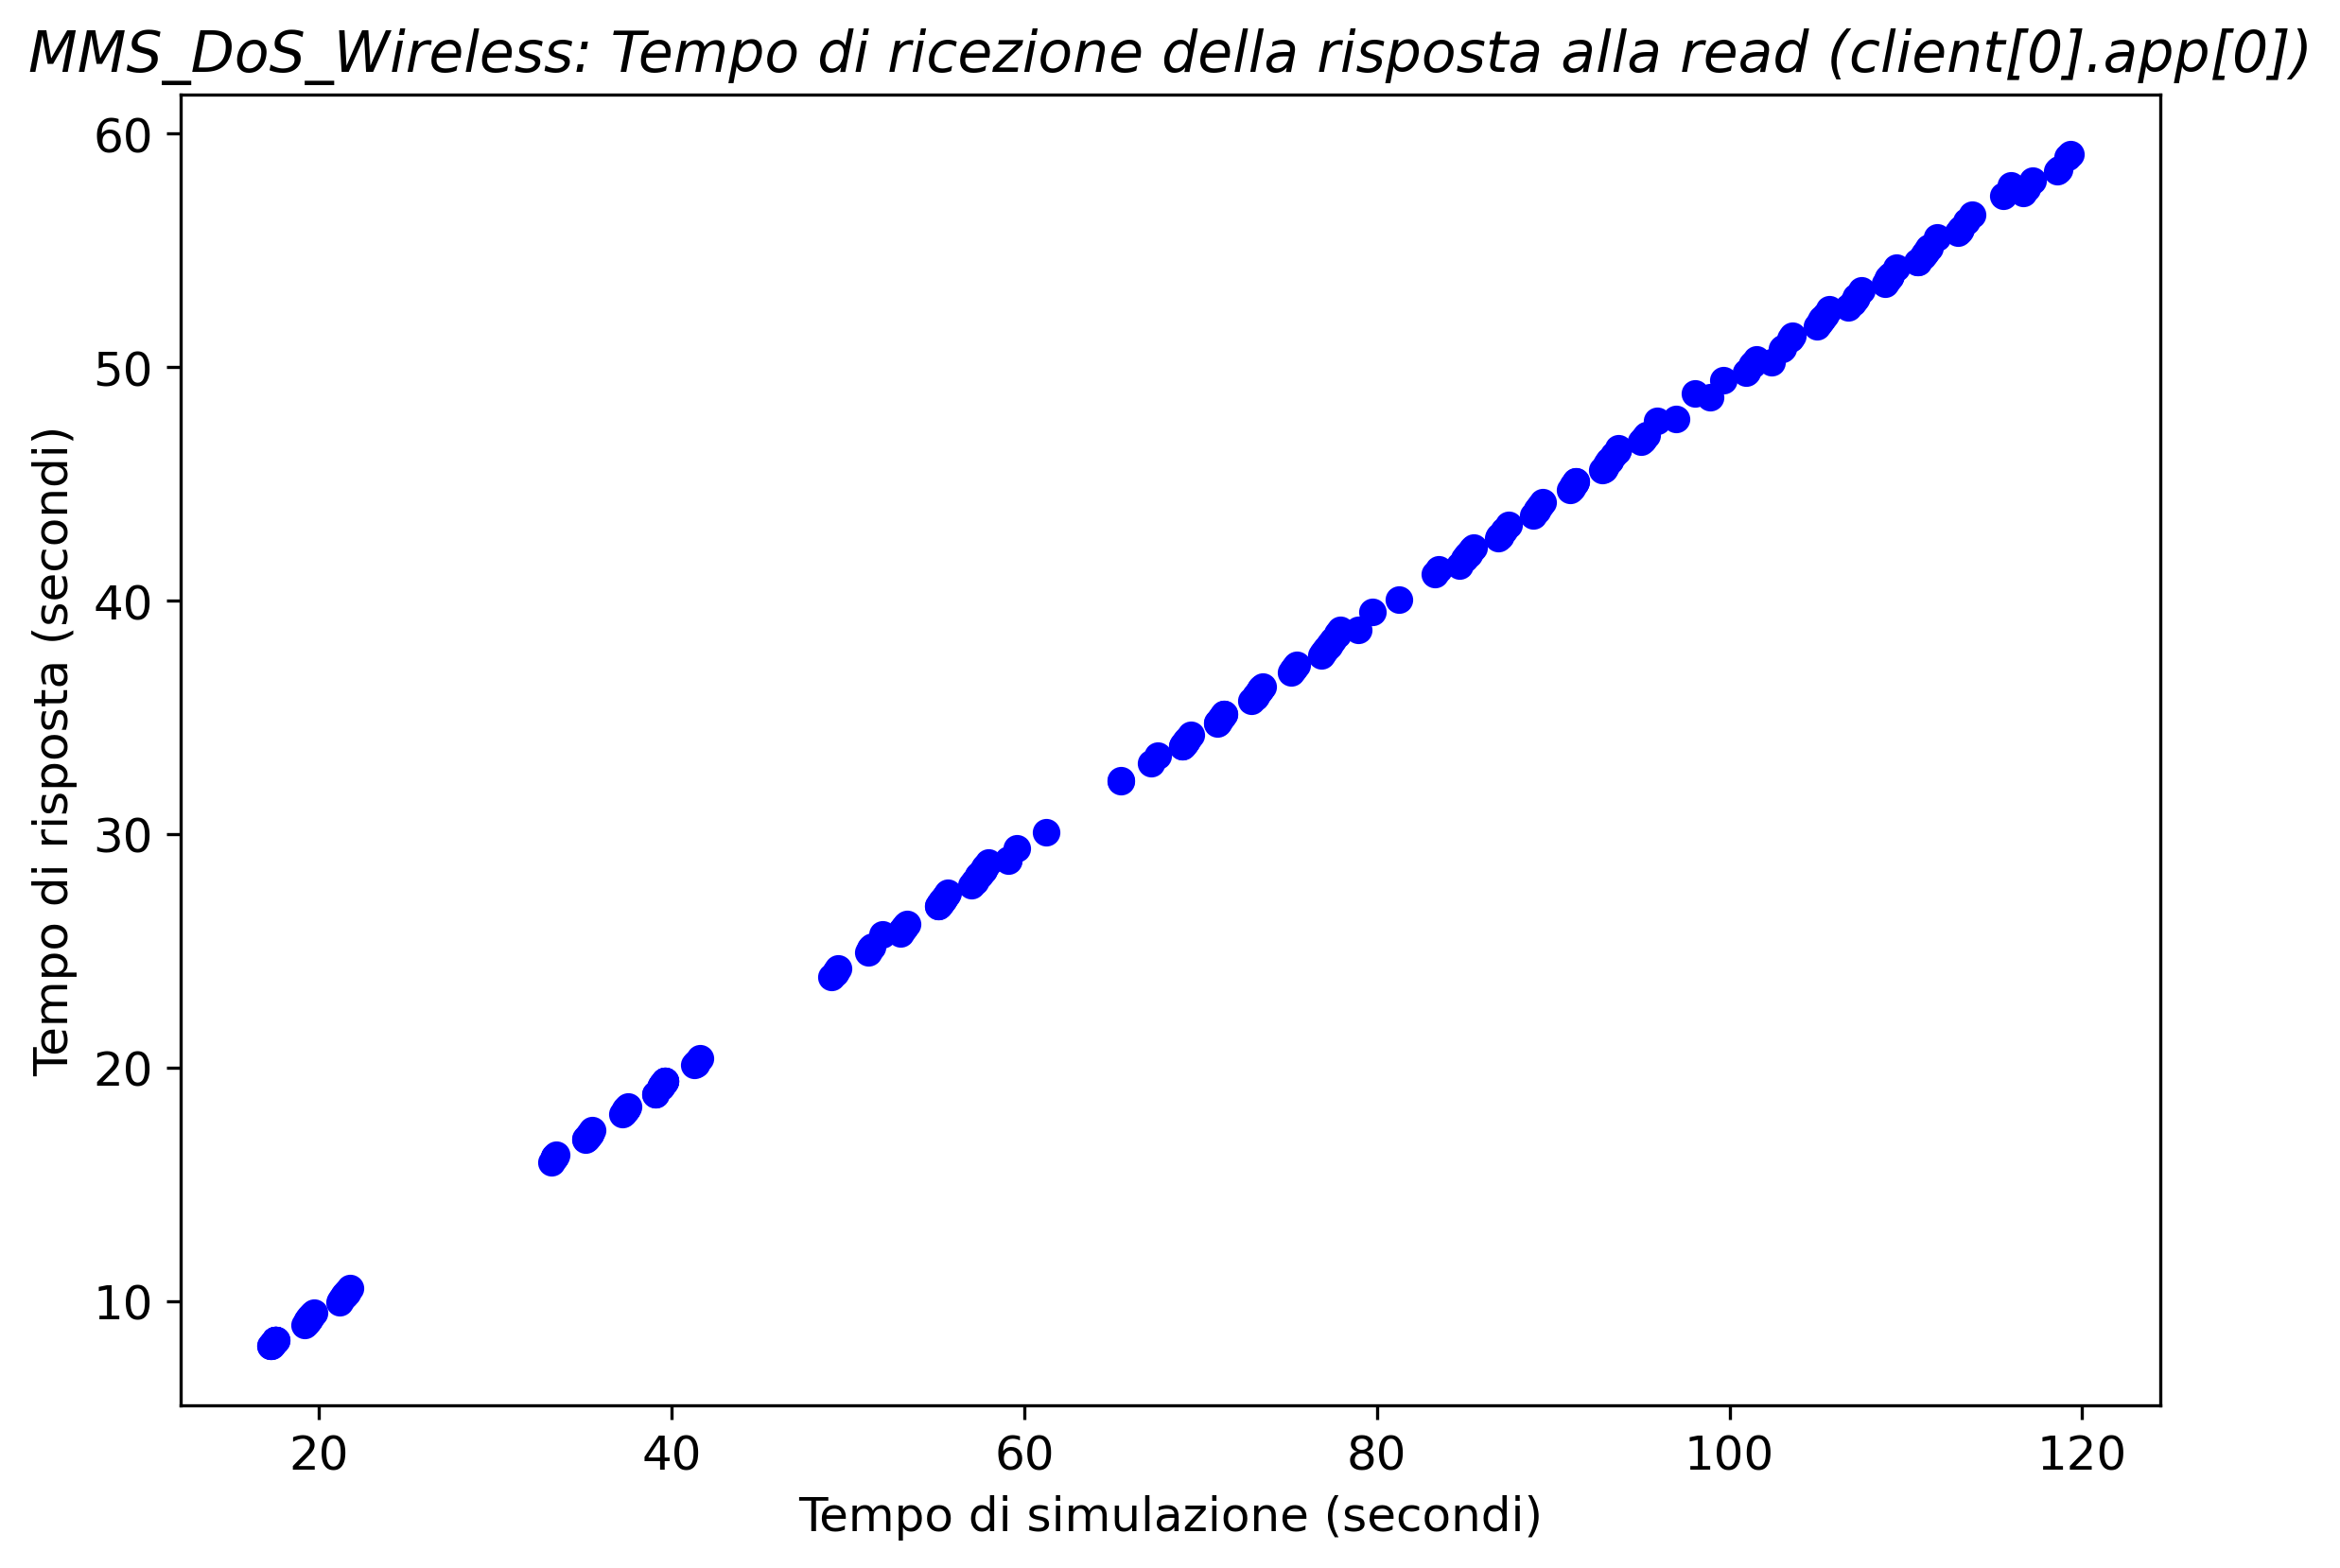

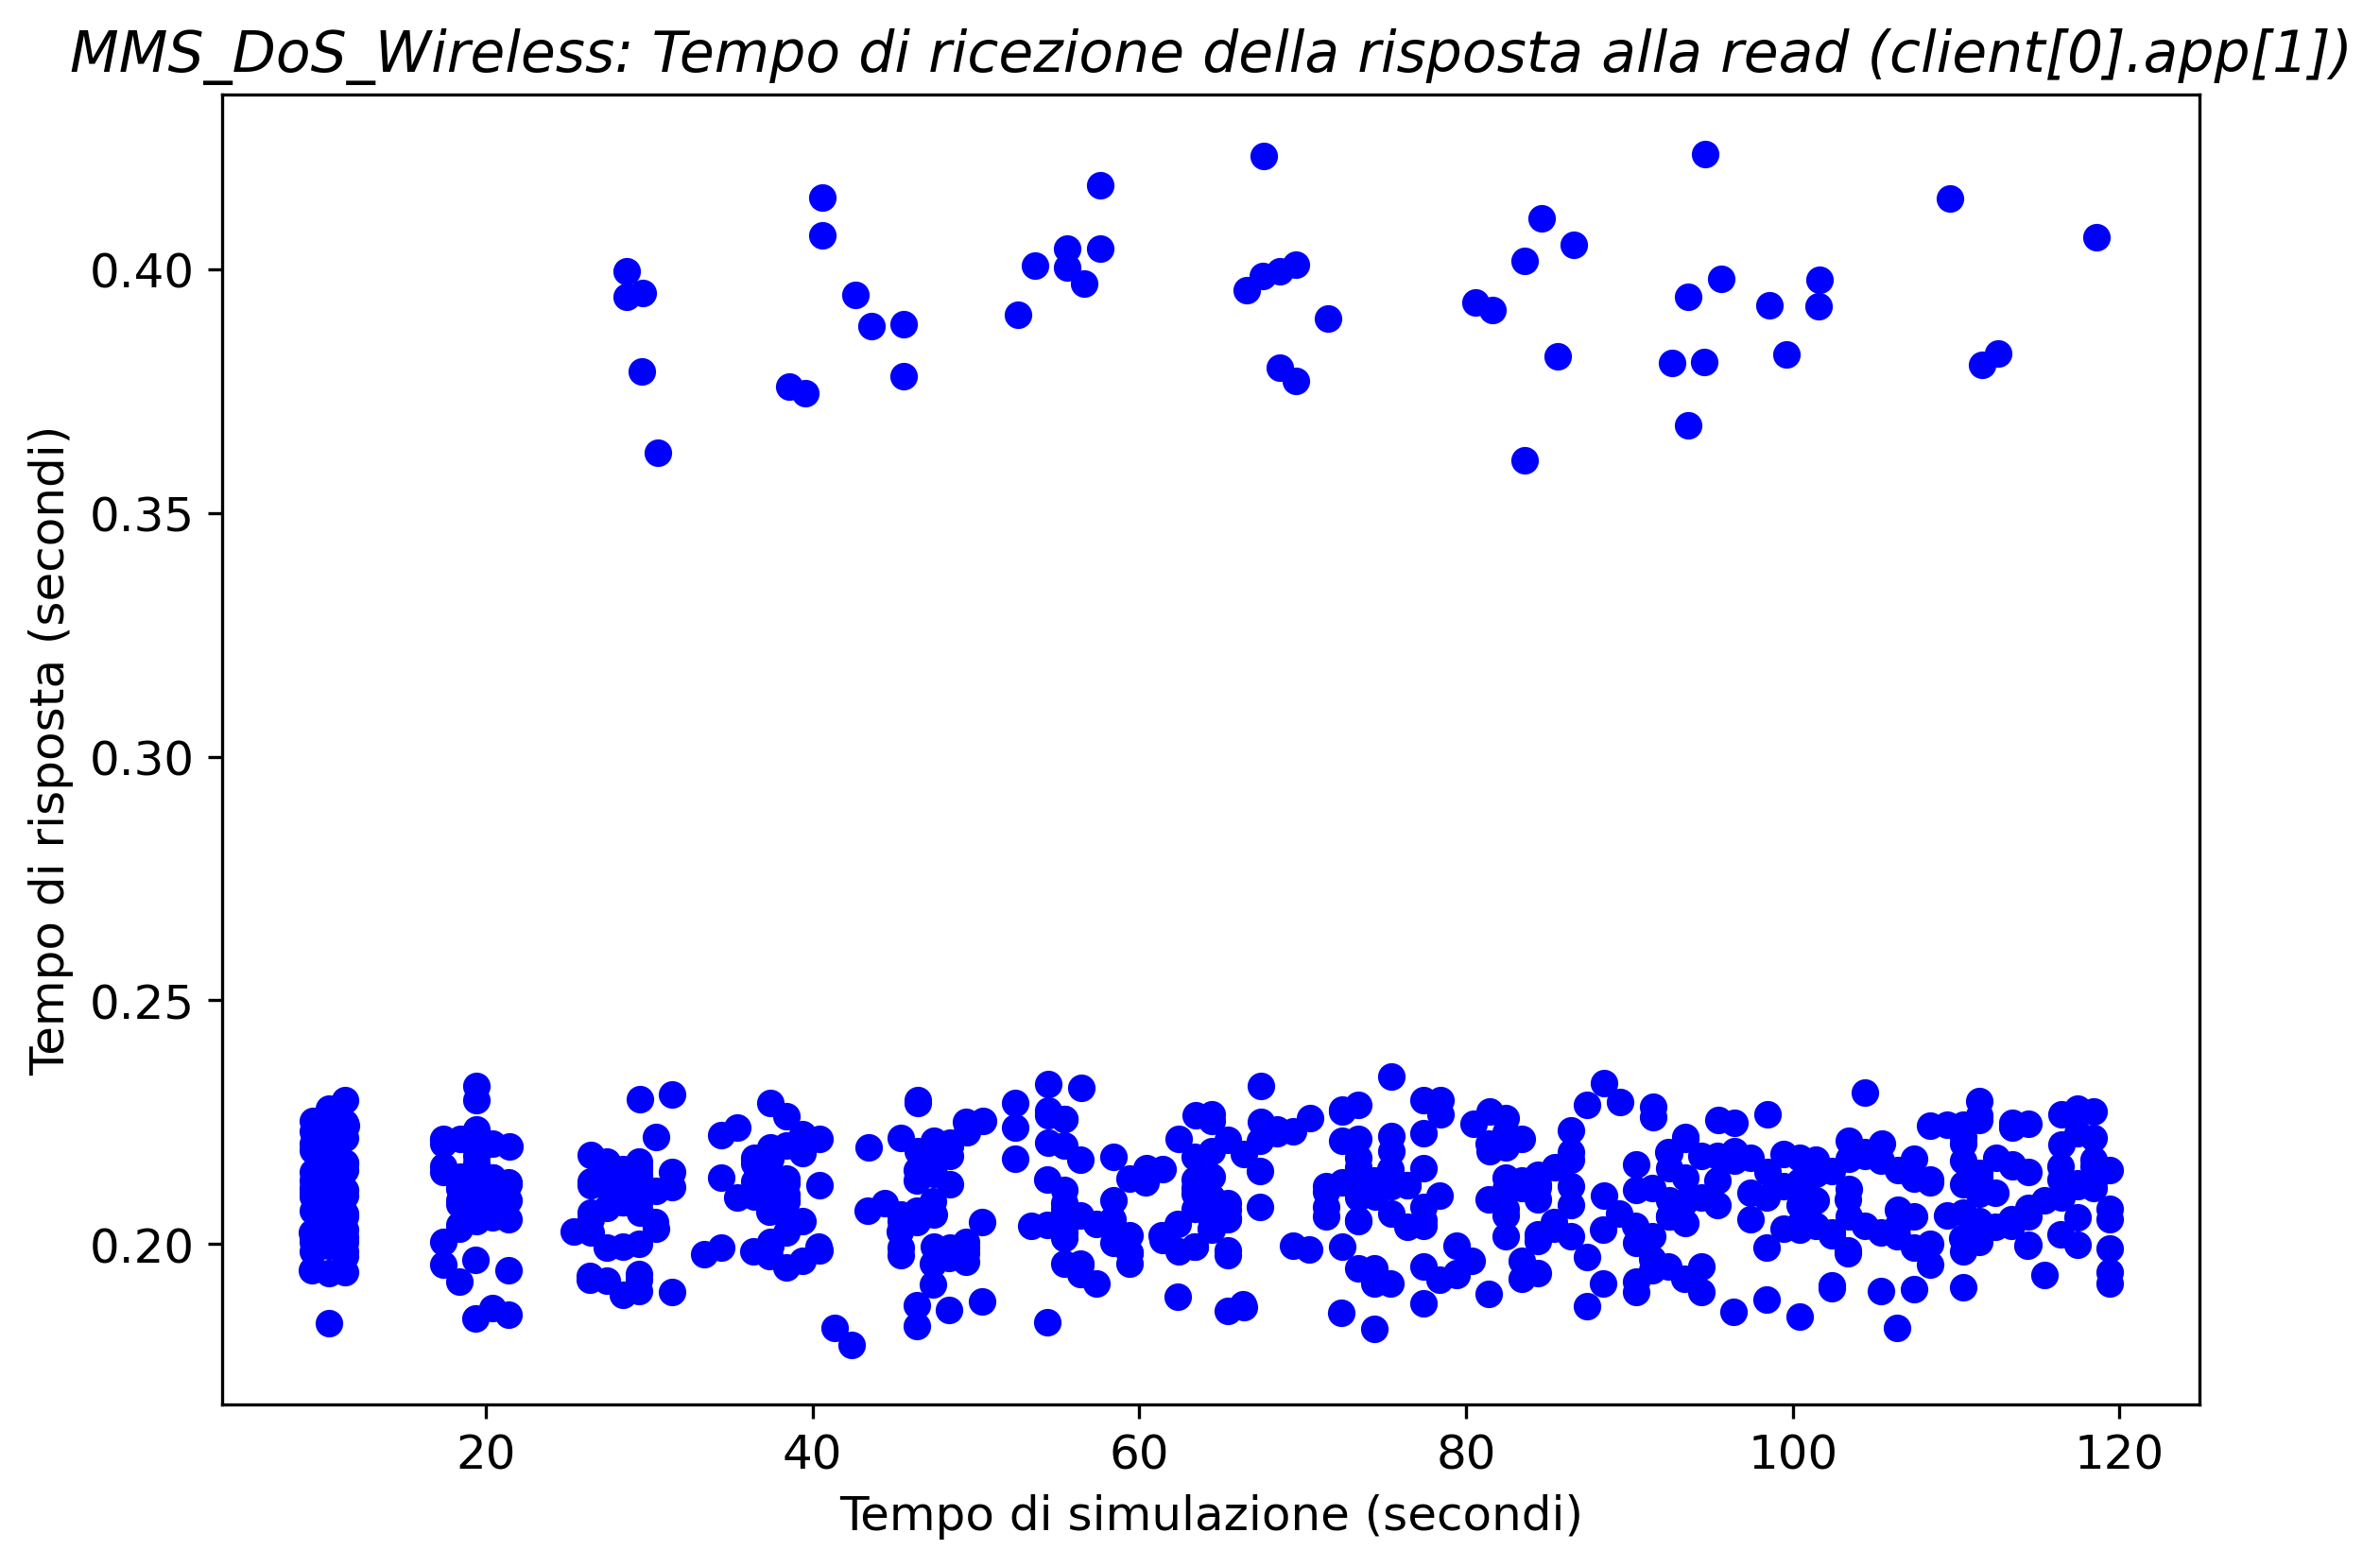

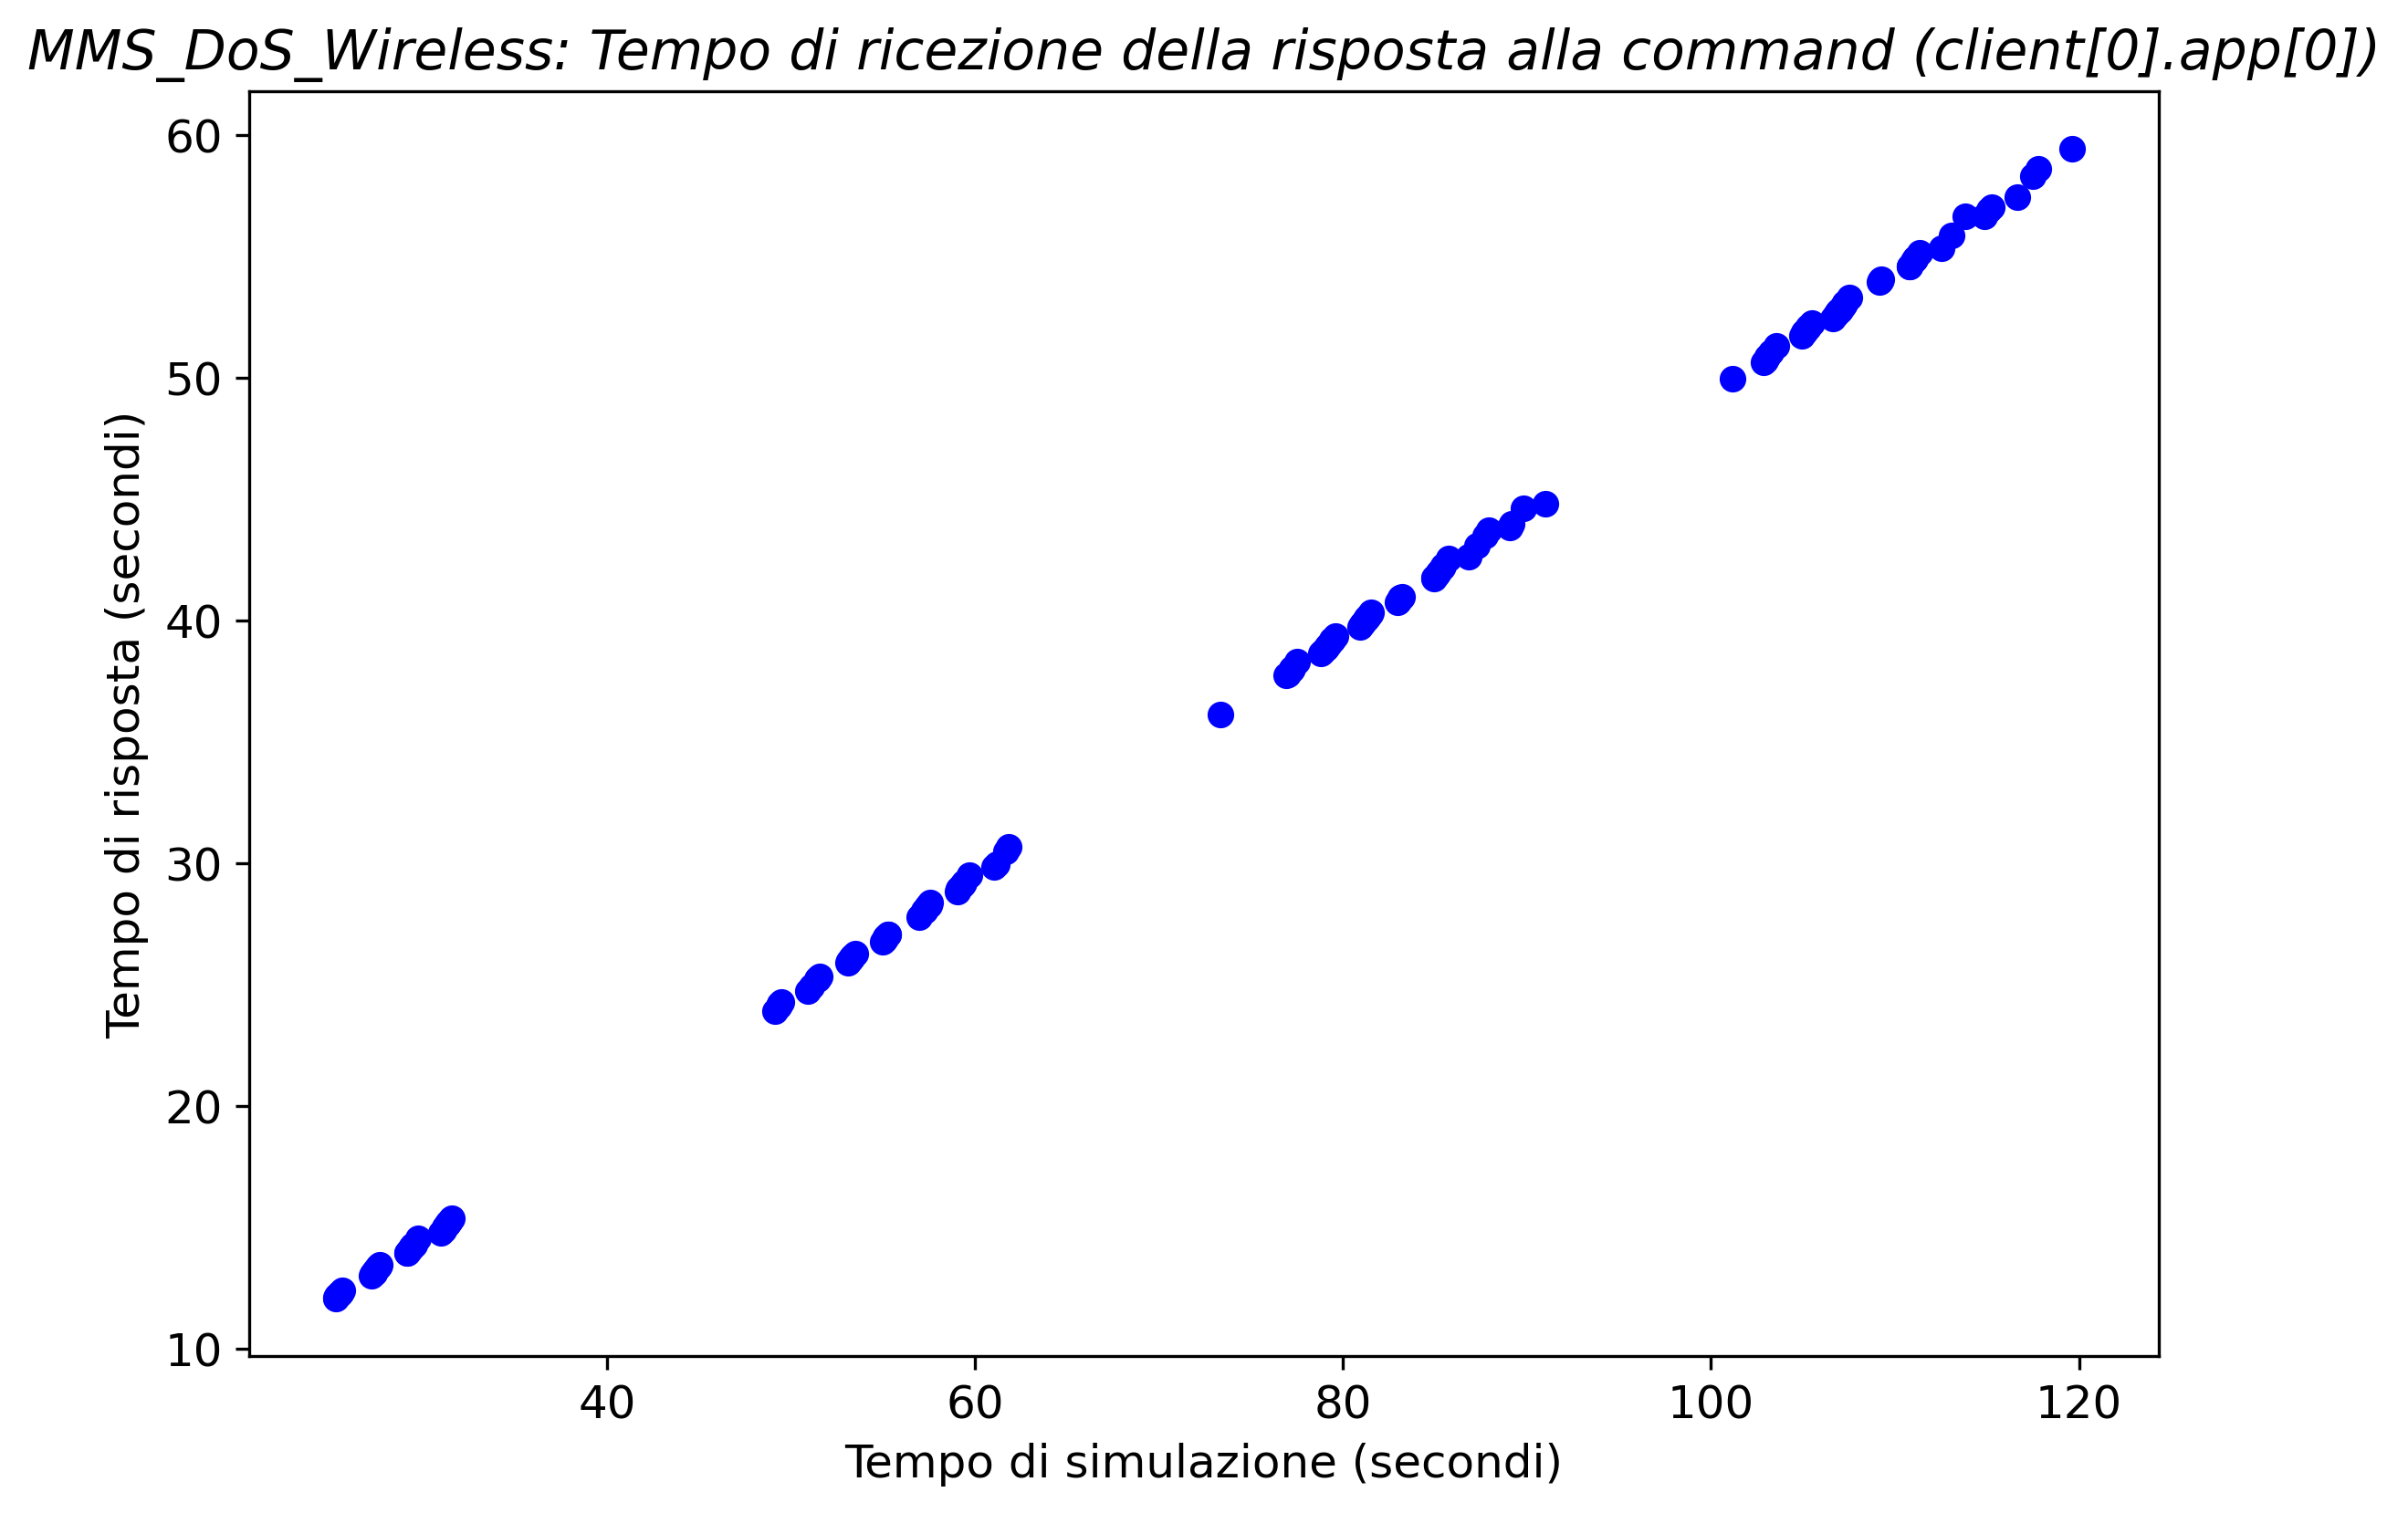

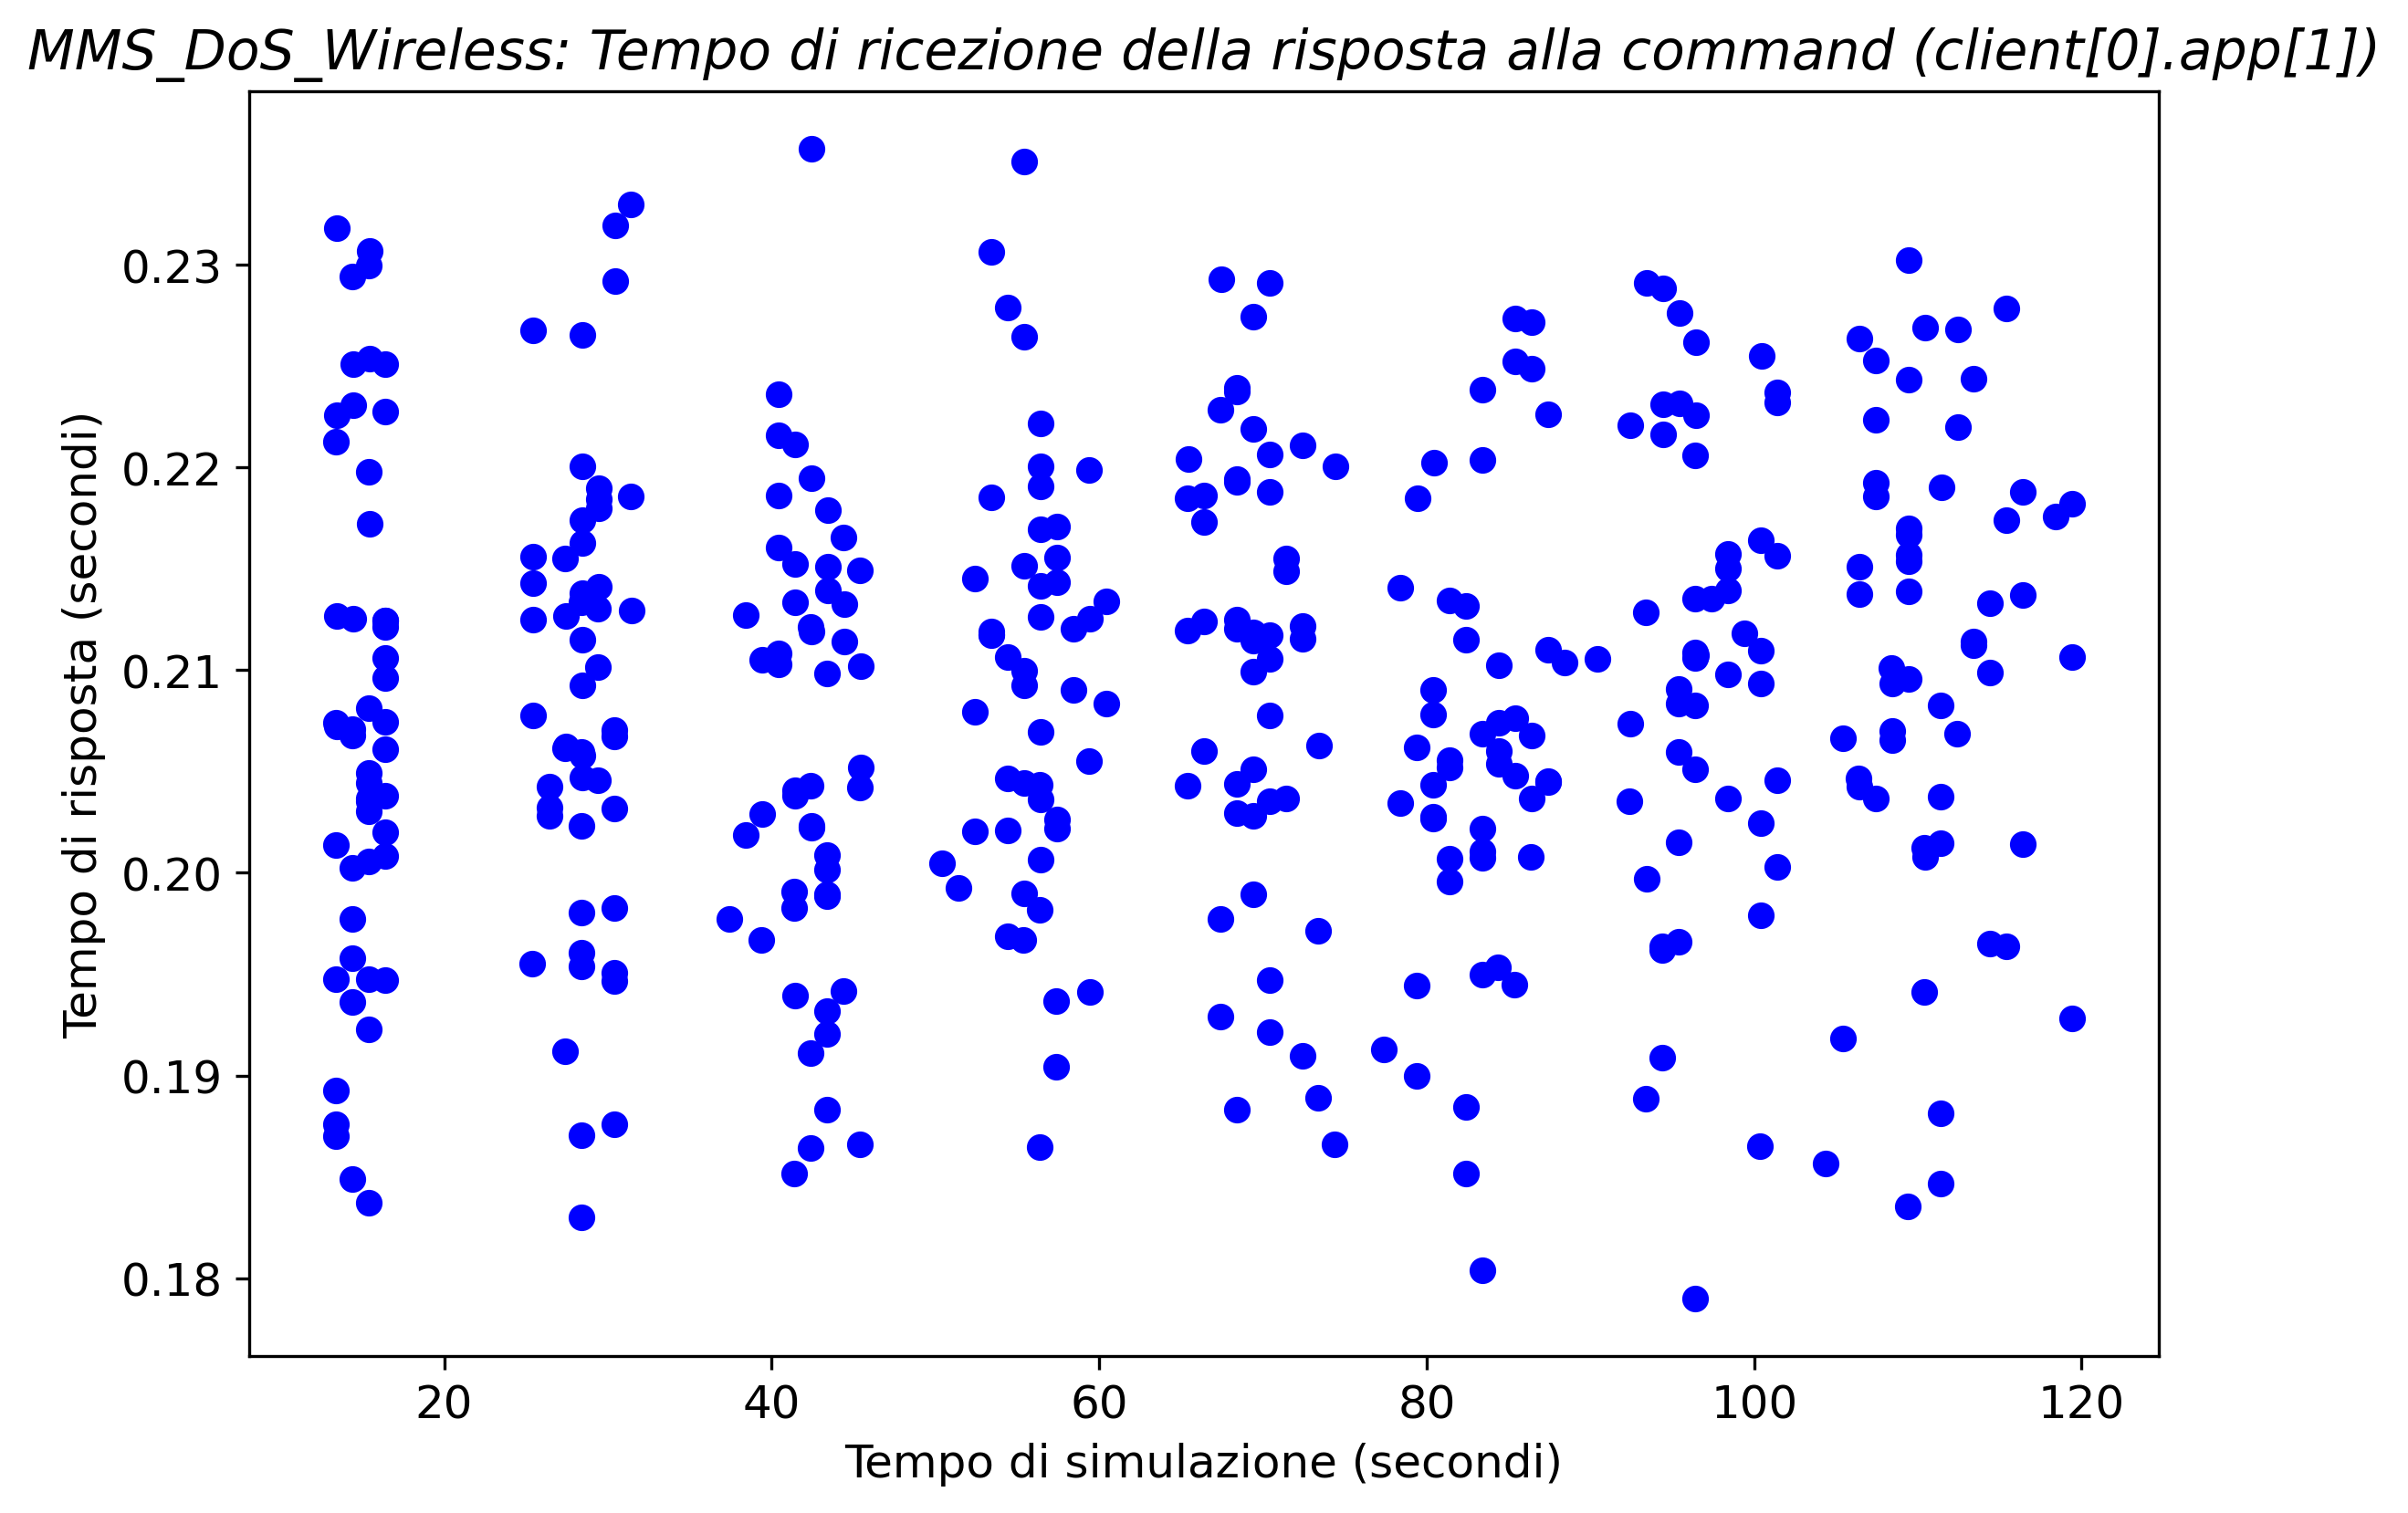

In [13]:
cliVecDfListReadTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read", xLab="Tempo di simulazione (secondi)", yLab="Tempo di risposta (secondi)", vecMeasName="readResponseReceivedTime")
cliVecDfListCommandTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command", xLab="Tempo di simulazione (secondi)", yLab="Tempo di risposta (secondi)", vecMeasName="commandResponseReceivedTime")

In [14]:
def confidenceInterval(data, confidence = 0.95):
    for (colName, colData) in data.iteritems():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * np.abs(scipy.stats.t.ppf((1-confidence)/2.0, n-1))
        relAcc = (h / m) * 100
        
        # m, m-h, m+h
        print("## Stat: " + colName)
        print("Average: " + str(round(m, 2)))
        print("Quantile: +-" + str(round(h, 2)))
        print("Relative accuracy: " + str(round(relAcc, 2)) + " %")
        if DEBUG:   
            interval = scipy.stats.t.interval(confidence, df=n-1, loc=m, scale=se)
            print("Debug interval: " + str((interval[1] - interval[0])/2))
         

Confidence interval for the different statistics

In [15]:
conf = 0.95
for i in range(numClients):
    for j in range(numServers):
        print("\n** " + simName + ": Confidence intervals for client[" + str(i) + "].app[" + str(j) + "] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(i+1)*j], conf)


** MMS_DoS_Wireless: Confidence intervals for client[0].app[0] at 95.0%  **
## Stat: readSent
Average: 12.74
Quantile: +-0.13
Relative accuracy: 0.99 %
Debug interval: 0.1259240733885214
## Stat: commandSent
Average: 8.24
Quantile: +-0.12
Relative accuracy: 1.49 %
Debug interval: 0.1226079544684886
## Stat: readResponse
Average: 6.1
Quantile: +-0.1
Relative accuracy: 1.7 %
Debug interval: 0.10350895071219135
## Stat: commandResponse
Average: 3.98
Quantile: +-0.04
Relative accuracy: 1.01 %
Debug interval: 0.04019150468978405
## Stat: readResponseTimeout
Average: 0.0
Quantile: +-0.0
Relative accuracy: nan %
Debug interval: nan
## Stat: commandResponseTimeout
Average: 0.0
Quantile: +-0.0
Relative accuracy: nan %
Debug interval: nan

** MMS_DoS_Wireless: Confidence intervals for client[0].app[1] at 95.0%  **
## Stat: readSent
Average: 12.58
Quantile: +-0.15
Relative accuracy: 1.22 %
Debug interval: 0.1528830517363886
## Stat: commandSent
Average: 8.1
Quantile: +-0.09
Relative accuracy: 1.

/tmp/ipykernel_65064/2305554413.py:7: RuntimeWarning: invalid value encountered in double_scalars
  relAcc = (h / m) * 100
/home/dosclic98/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/dosclic98/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [16]:
for j in range(numServers):
    print("\n** " + simName + ": Confidence intervals for evilClient.app[" + str(j) + "] at " + str(conf*100) + "%  **")
    confidenceInterval(evilScaDfList[j], conf)
    


** MMS_DoS_Wireless: Confidence intervals for evilClient.app[0] at 95.0%  **
## Stat: measureBlock
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: measureCompromised
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: readRequestBlock
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: readRequestCompromised
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: commandRequestBlock
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: commandRequestCompromised
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: readResponseBlock
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: readResponseCompromised
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval: nan
## Stat: commandResponseBlock
Average: nan
Quantile: +-nan
Relative accuracy: nan %
Debug interval

/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
